In [1]:
# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Using TensorFlow backend.
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4423680/4422102 [==============================] - 13s 3us/step


C:\Users\karth\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\karth\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=0.725, d2=0.694 g=0.692


C:\Users\karth\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/468, d1=0.658, d2=0.697 g=0.690
>1, 3/468, d1=0.596, d2=0.702 g=0.685
>1, 4/468, d1=0.545, d2=0.709 g=0.678
>1, 5/468, d1=0.492, d2=0.719 g=0.669
>1, 6/468, d1=0.433, d2=0.737 g=0.659
>1, 7/468, d1=0.389, d2=0.754 g=0.644
>1, 8/468, d1=0.356, d2=0.776 g=0.633
>1, 9/468, d1=0.323, d2=0.802 g=0.635
>1, 10/468, d1=0.324, d2=0.791 g=0.646
>1, 11/468, d1=0.300, d2=0.773 g=0.687
>1, 12/468, d1=0.309, d2=0.711 g=0.750
>1, 13/468, d1=0.276, d2=0.641 g=0.839
>1, 14/468, d1=0.301, d2=0.582 g=0.921
>1, 15/468, d1=0.311, d2=0.537 g=0.942
>1, 16/468, d1=0.361, d2=0.565 g=0.898
>1, 17/468, d1=0.321, d2=0.635 g=0.827
>1, 18/468, d1=0.320, d2=0.704 g=0.770
>1, 19/468, d1=0.276, d2=0.764 g=0.744
>1, 20/468, d1=0.205, d2=0.762 g=0.752
>1, 21/468, d1=0.290, d2=0.735 g=0.787
>1, 22/468, d1=0.185, d2=0.706 g=0.816
>1, 23/468, d1=0.179, d2=0.679 g=0.835
>1, 24/468, d1=0.152, d2=0.663 g=0.871
>1, 25/468, d1=0.141, d2=0.626 g=0.908
>1, 26/468, d1=0.144, d2=0.601 g=0.921
>1, 27/468, d1=0.141, d2=0.600 g=

>1, 210/468, d1=0.709, d2=0.724 g=0.748
>1, 211/468, d1=0.726, d2=0.690 g=0.791
>1, 212/468, d1=0.704, d2=0.707 g=0.809
>1, 213/468, d1=0.703, d2=0.705 g=0.766
>1, 214/468, d1=0.692, d2=0.707 g=0.785
>1, 215/468, d1=0.720, d2=0.719 g=0.758
>1, 216/468, d1=0.729, d2=0.727 g=0.741
>1, 217/468, d1=0.715, d2=0.728 g=0.762
>1, 218/468, d1=0.746, d2=0.724 g=0.729
>1, 219/468, d1=0.712, d2=0.714 g=0.765
>1, 220/468, d1=0.763, d2=0.709 g=0.794
>1, 221/468, d1=0.752, d2=0.665 g=0.794
>1, 222/468, d1=0.718, d2=0.640 g=0.804
>1, 223/468, d1=0.715, d2=0.633 g=0.841
>1, 224/468, d1=0.707, d2=0.635 g=0.856
>1, 225/468, d1=0.732, d2=0.612 g=0.862
>1, 226/468, d1=0.705, d2=0.639 g=0.853
>1, 227/468, d1=0.683, d2=0.612 g=0.848
>1, 228/468, d1=0.685, d2=0.654 g=0.851
>1, 229/468, d1=0.681, d2=0.627 g=0.842
>1, 230/468, d1=0.705, d2=0.651 g=0.812
>1, 231/468, d1=0.692, d2=0.681 g=0.804
>1, 232/468, d1=0.722, d2=0.719 g=0.768
>1, 233/468, d1=0.715, d2=0.722 g=0.771
>1, 234/468, d1=0.739, d2=0.690 g=0.773


>1, 415/468, d1=0.745, d2=0.710 g=0.844
>1, 416/468, d1=0.708, d2=0.628 g=0.862
>1, 417/468, d1=0.685, d2=0.612 g=0.917
>1, 418/468, d1=0.732, d2=0.560 g=0.929
>1, 419/468, d1=0.731, d2=0.573 g=0.977
>1, 420/468, d1=0.739, d2=0.572 g=0.944
>1, 421/468, d1=0.722, d2=0.573 g=0.943
>1, 422/468, d1=0.716, d2=0.607 g=0.905
>1, 423/468, d1=0.765, d2=0.646 g=0.823
>1, 424/468, d1=0.735, d2=0.664 g=0.777
>1, 425/468, d1=0.733, d2=0.710 g=0.794
>1, 426/468, d1=0.714, d2=0.704 g=0.746
>1, 427/468, d1=0.696, d2=0.771 g=0.707
>1, 428/468, d1=0.705, d2=0.733 g=0.713
>1, 429/468, d1=0.697, d2=0.727 g=0.704
>1, 430/468, d1=0.665, d2=0.707 g=0.715
>1, 431/468, d1=0.665, d2=0.724 g=0.713
>1, 432/468, d1=0.686, d2=0.697 g=0.739
>1, 433/468, d1=0.670, d2=0.691 g=0.738
>1, 434/468, d1=0.700, d2=0.677 g=0.778
>1, 435/468, d1=0.708, d2=0.667 g=0.802
>1, 436/468, d1=0.679, d2=0.650 g=0.832
>1, 437/468, d1=0.651, d2=0.612 g=0.845
>1, 438/468, d1=0.686, d2=0.586 g=0.853
>1, 439/468, d1=0.650, d2=0.592 g=0.865


>2, 155/468, d1=0.695, d2=0.570 g=0.911
>2, 156/468, d1=0.695, d2=0.554 g=0.893
>2, 157/468, d1=0.719, d2=0.597 g=0.867
>2, 158/468, d1=0.669, d2=0.604 g=0.799
>2, 159/468, d1=0.656, d2=0.660 g=0.771
>2, 160/468, d1=0.693, d2=0.723 g=0.721
>2, 161/468, d1=0.670, d2=0.713 g=0.692
>2, 162/468, d1=0.662, d2=0.793 g=0.653
>2, 163/468, d1=0.657, d2=0.778 g=0.654
>2, 164/468, d1=0.671, d2=0.781 g=0.652
>2, 165/468, d1=0.664, d2=0.765 g=0.663
>2, 166/468, d1=0.673, d2=0.751 g=0.670
>2, 167/468, d1=0.678, d2=0.736 g=0.706
>2, 168/468, d1=0.687, d2=0.718 g=0.732
>2, 169/468, d1=0.695, d2=0.691 g=0.744
>2, 170/468, d1=0.671, d2=0.668 g=0.765
>2, 171/468, d1=0.693, d2=0.650 g=0.787
>2, 172/468, d1=0.683, d2=0.638 g=0.793
>2, 173/468, d1=0.702, d2=0.622 g=0.817
>2, 174/468, d1=0.676, d2=0.625 g=0.797
>2, 175/468, d1=0.682, d2=0.618 g=0.814
>2, 176/468, d1=0.692, d2=0.629 g=0.813
>2, 177/468, d1=0.633, d2=0.637 g=0.784
>2, 178/468, d1=0.653, d2=0.644 g=0.776
>2, 179/468, d1=0.682, d2=0.684 g=0.766


>2, 360/468, d1=0.682, d2=0.646 g=0.763
>2, 361/468, d1=0.657, d2=0.652 g=0.775
>2, 362/468, d1=0.643, d2=0.673 g=0.756
>2, 363/468, d1=0.666, d2=0.669 g=0.751
>2, 364/468, d1=0.651, d2=0.680 g=0.754
>2, 365/468, d1=0.663, d2=0.705 g=0.760
>2, 366/468, d1=0.673, d2=0.726 g=0.721
>2, 367/468, d1=0.669, d2=0.686 g=0.732
>2, 368/468, d1=0.680, d2=0.676 g=0.761
>2, 369/468, d1=0.655, d2=0.675 g=0.754
>2, 370/468, d1=0.683, d2=0.659 g=0.766
>2, 371/468, d1=0.683, d2=0.663 g=0.782
>2, 372/468, d1=0.668, d2=0.667 g=0.782
>2, 373/468, d1=0.690, d2=0.639 g=0.789
>2, 374/468, d1=0.687, d2=0.618 g=0.779
>2, 375/468, d1=0.691, d2=0.634 g=0.793
>2, 376/468, d1=0.681, d2=0.641 g=0.768
>2, 377/468, d1=0.671, d2=0.639 g=0.792
>2, 378/468, d1=0.695, d2=0.676 g=0.758
>2, 379/468, d1=0.674, d2=0.668 g=0.751
>2, 380/468, d1=0.671, d2=0.695 g=0.730
>2, 381/468, d1=0.669, d2=0.707 g=0.730
>2, 382/468, d1=0.675, d2=0.686 g=0.728
>2, 383/468, d1=0.658, d2=0.683 g=0.726
>2, 384/468, d1=0.647, d2=0.687 g=0.726


>3, 100/468, d1=0.699, d2=0.690 g=0.731
>3, 101/468, d1=0.685, d2=0.699 g=0.731
>3, 102/468, d1=0.677, d2=0.662 g=0.746
>3, 103/468, d1=0.678, d2=0.687 g=0.758
>3, 104/468, d1=0.665, d2=0.675 g=0.750
>3, 105/468, d1=0.646, d2=0.668 g=0.773
>3, 106/468, d1=0.691, d2=0.643 g=0.761
>3, 107/468, d1=0.669, d2=0.671 g=0.778
>3, 108/468, d1=0.667, d2=0.653 g=0.770
>3, 109/468, d1=0.644, d2=0.653 g=0.767
>3, 110/468, d1=0.654, d2=0.672 g=0.755
>3, 111/468, d1=0.659, d2=0.657 g=0.773
>3, 112/468, d1=0.636, d2=0.678 g=0.774
>3, 113/468, d1=0.653, d2=0.661 g=0.782
>3, 114/468, d1=0.662, d2=0.642 g=0.769
>3, 115/468, d1=0.663, d2=0.654 g=0.764
>3, 116/468, d1=0.637, d2=0.642 g=0.781
>3, 117/468, d1=0.654, d2=0.650 g=0.767
>3, 118/468, d1=0.669, d2=0.655 g=0.775
>3, 119/468, d1=0.685, d2=0.653 g=0.769
>3, 120/468, d1=0.681, d2=0.646 g=0.772
>3, 121/468, d1=0.657, d2=0.658 g=0.751
>3, 122/468, d1=0.695, d2=0.673 g=0.760
>3, 123/468, d1=0.659, d2=0.670 g=0.753
>3, 124/468, d1=0.711, d2=0.672 g=0.753


>3, 305/468, d1=0.683, d2=0.643 g=0.810
>3, 306/468, d1=0.711, d2=0.638 g=0.791
>3, 307/468, d1=0.709, d2=0.668 g=0.781
>3, 308/468, d1=0.718, d2=0.666 g=0.773
>3, 309/468, d1=0.674, d2=0.647 g=0.763
>3, 310/468, d1=0.685, d2=0.665 g=0.761
>3, 311/468, d1=0.660, d2=0.672 g=0.769
>3, 312/468, d1=0.691, d2=0.658 g=0.789
>3, 313/468, d1=0.671, d2=0.657 g=0.782
>3, 314/468, d1=0.682, d2=0.636 g=0.782
>3, 315/468, d1=0.662, d2=0.645 g=0.805
>3, 316/468, d1=0.650, d2=0.640 g=0.779
>3, 317/468, d1=0.671, d2=0.666 g=0.773
>3, 318/468, d1=0.659, d2=0.661 g=0.774
>3, 319/468, d1=0.641, d2=0.642 g=0.771
>3, 320/468, d1=0.628, d2=0.663 g=0.761
>3, 321/468, d1=0.664, d2=0.654 g=0.778
>3, 322/468, d1=0.622, d2=0.673 g=0.785
>3, 323/468, d1=0.683, d2=0.665 g=0.791
>3, 324/468, d1=0.664, d2=0.666 g=0.818
>3, 325/468, d1=0.692, d2=0.625 g=0.825
>3, 326/468, d1=0.663, d2=0.629 g=0.841
>3, 327/468, d1=0.703, d2=0.609 g=0.866
>3, 328/468, d1=0.756, d2=0.607 g=0.847
>3, 329/468, d1=0.704, d2=0.598 g=0.849


>4, 44/468, d1=0.667, d2=0.640 g=0.812
>4, 45/468, d1=0.666, d2=0.649 g=0.801
>4, 46/468, d1=0.629, d2=0.658 g=0.799
>4, 47/468, d1=0.635, d2=0.641 g=0.786
>4, 48/468, d1=0.640, d2=0.634 g=0.794
>4, 49/468, d1=0.627, d2=0.638 g=0.776
>4, 50/468, d1=0.642, d2=0.662 g=0.791
>4, 51/468, d1=0.645, d2=0.638 g=0.791
>4, 52/468, d1=0.647, d2=0.667 g=0.787
>4, 53/468, d1=0.646, d2=0.663 g=0.792
>4, 54/468, d1=0.655, d2=0.654 g=0.798
>4, 55/468, d1=0.679, d2=0.651 g=0.815
>4, 56/468, d1=0.672, d2=0.627 g=0.832
>4, 57/468, d1=0.709, d2=0.615 g=0.840
>4, 58/468, d1=0.722, d2=0.593 g=0.846
>4, 59/468, d1=0.686, d2=0.599 g=0.828
>4, 60/468, d1=0.676, d2=0.633 g=0.824
>4, 61/468, d1=0.686, d2=0.633 g=0.809
>4, 62/468, d1=0.665, d2=0.643 g=0.785
>4, 63/468, d1=0.676, d2=0.659 g=0.774
>4, 64/468, d1=0.676, d2=0.650 g=0.792
>4, 65/468, d1=0.640, d2=0.659 g=0.777
>4, 66/468, d1=0.650, d2=0.658 g=0.764
>4, 67/468, d1=0.620, d2=0.664 g=0.765
>4, 68/468, d1=0.636, d2=0.673 g=0.757
>4, 69/468, d1=0.637, d2=

>4, 251/468, d1=0.663, d2=0.603 g=0.826
>4, 252/468, d1=0.691, d2=0.648 g=0.804
>4, 253/468, d1=0.667, d2=0.684 g=0.762
>4, 254/468, d1=0.672, d2=0.676 g=0.766
>4, 255/468, d1=0.671, d2=0.671 g=0.769
>4, 256/468, d1=0.642, d2=0.676 g=0.788
>4, 257/468, d1=0.625, d2=0.665 g=0.768
>4, 258/468, d1=0.652, d2=0.650 g=0.796
>4, 259/468, d1=0.653, d2=0.682 g=0.763
>4, 260/468, d1=0.615, d2=0.694 g=0.784
>4, 261/468, d1=0.624, d2=0.685 g=0.748
>4, 262/468, d1=0.647, d2=0.731 g=0.750
>4, 263/468, d1=0.633, d2=0.695 g=0.799
>4, 264/468, d1=0.681, d2=0.676 g=0.855
>4, 265/468, d1=0.689, d2=0.599 g=0.893
>4, 266/468, d1=0.742, d2=0.571 g=0.917
>4, 267/468, d1=0.709, d2=0.589 g=0.872
>4, 268/468, d1=0.712, d2=0.585 g=0.844
>4, 269/468, d1=0.699, d2=0.650 g=0.793
>4, 270/468, d1=0.683, d2=0.644 g=0.771
>4, 271/468, d1=0.637, d2=0.650 g=0.779
>4, 272/468, d1=0.657, d2=0.634 g=0.789
>4, 273/468, d1=0.605, d2=0.643 g=0.820
>4, 274/468, d1=0.609, d2=0.662 g=0.792
>4, 275/468, d1=0.624, d2=0.710 g=0.788


>4, 456/468, d1=0.721, d2=0.564 g=0.887
>4, 457/468, d1=0.722, d2=0.652 g=0.840
>4, 458/468, d1=0.700, d2=0.652 g=0.807
>4, 459/468, d1=0.711, d2=0.634 g=0.782
>4, 460/468, d1=0.651, d2=0.629 g=0.771
>4, 461/468, d1=0.656, d2=0.667 g=0.772
>4, 462/468, d1=0.662, d2=0.692 g=0.770
>4, 463/468, d1=0.621, d2=0.674 g=0.758
>4, 464/468, d1=0.644, d2=0.686 g=0.748
>4, 465/468, d1=0.641, d2=0.703 g=0.771
>4, 466/468, d1=0.628, d2=0.730 g=0.776
>4, 467/468, d1=0.662, d2=0.683 g=0.763
>4, 468/468, d1=0.679, d2=0.653 g=0.791
>5, 1/468, d1=0.684, d2=0.639 g=0.796
>5, 2/468, d1=0.684, d2=0.656 g=0.804
>5, 3/468, d1=0.703, d2=0.630 g=0.807
>5, 4/468, d1=0.678, d2=0.628 g=0.801
>5, 5/468, d1=0.694, d2=0.659 g=0.812
>5, 6/468, d1=0.694, d2=0.648 g=0.791
>5, 7/468, d1=0.659, d2=0.645 g=0.794
>5, 8/468, d1=0.681, d2=0.666 g=0.777
>5, 9/468, d1=0.670, d2=0.655 g=0.771
>5, 10/468, d1=0.686, d2=0.668 g=0.758
>5, 11/468, d1=0.641, d2=0.703 g=0.742
>5, 12/468, d1=0.642, d2=0.680 g=0.754
>5, 13/468, d1=0.625,

>5, 196/468, d1=0.692, d2=0.669 g=0.759
>5, 197/468, d1=0.654, d2=0.684 g=0.742
>5, 198/468, d1=0.685, d2=0.676 g=0.758
>5, 199/468, d1=0.680, d2=0.677 g=0.728
>5, 200/468, d1=0.666, d2=0.687 g=0.753
>5, 201/468, d1=0.650, d2=0.701 g=0.743
>5, 202/468, d1=0.647, d2=0.714 g=0.769
>5, 203/468, d1=0.670, d2=0.682 g=0.769
>5, 204/468, d1=0.721, d2=0.681 g=0.785
>5, 205/468, d1=0.703, d2=0.668 g=0.775
>5, 206/468, d1=0.702, d2=0.673 g=0.791
>5, 207/468, d1=0.694, d2=0.648 g=0.794
>5, 208/468, d1=0.694, d2=0.661 g=0.780
>5, 209/468, d1=0.683, d2=0.673 g=0.779
>5, 210/468, d1=0.703, d2=0.667 g=0.753
>5, 211/468, d1=0.681, d2=0.674 g=0.780
>5, 212/468, d1=0.704, d2=0.654 g=0.751
>5, 213/468, d1=0.673, d2=0.684 g=0.765
>5, 214/468, d1=0.678, d2=0.688 g=0.762
>5, 215/468, d1=0.695, d2=0.657 g=0.743
>5, 216/468, d1=0.653, d2=0.672 g=0.748
>5, 217/468, d1=0.672, d2=0.681 g=0.741
>5, 218/468, d1=0.685, d2=0.702 g=0.751
>5, 219/468, d1=0.660, d2=0.697 g=0.766
>5, 220/468, d1=0.679, d2=0.708 g=0.784


>5, 401/468, d1=0.630, d2=0.696 g=0.744
>5, 402/468, d1=0.647, d2=0.707 g=0.728
>5, 403/468, d1=0.677, d2=0.737 g=0.719
>5, 404/468, d1=0.645, d2=0.697 g=0.745
>5, 405/468, d1=0.628, d2=0.724 g=0.728
>5, 406/468, d1=0.679, d2=0.683 g=0.765
>5, 407/468, d1=0.701, d2=0.695 g=0.815
>5, 408/468, d1=0.687, d2=0.631 g=0.862
>5, 409/468, d1=0.724, d2=0.603 g=0.914
>5, 410/468, d1=0.720, d2=0.560 g=0.877
>5, 411/468, d1=0.782, d2=0.606 g=0.822
>5, 412/468, d1=0.694, d2=0.643 g=0.801
>5, 413/468, d1=0.715, d2=0.699 g=0.707
>5, 414/468, d1=0.686, d2=0.718 g=0.738
>5, 415/468, d1=0.689, d2=0.715 g=0.720
>5, 416/468, d1=0.704, d2=0.701 g=0.742
>5, 417/468, d1=0.688, d2=0.681 g=0.770
>5, 418/468, d1=0.637, d2=0.660 g=0.796
>5, 419/468, d1=0.657, d2=0.639 g=0.805
>5, 420/468, d1=0.588, d2=0.654 g=0.823
>5, 421/468, d1=0.641, d2=0.649 g=0.768
>5, 422/468, d1=0.648, d2=0.726 g=0.707
>5, 423/468, d1=0.599, d2=0.795 g=0.699
>5, 424/468, d1=0.644, d2=0.808 g=0.703
>5, 425/468, d1=0.647, d2=0.762 g=0.749


>6, 141/468, d1=0.622, d2=0.678 g=0.773
>6, 142/468, d1=0.681, d2=0.719 g=0.730
>6, 143/468, d1=0.644, d2=0.738 g=0.706
>6, 144/468, d1=0.658, d2=0.819 g=0.712
>6, 145/468, d1=0.728, d2=0.684 g=0.729
>6, 146/468, d1=0.695, d2=0.692 g=0.767
>6, 147/468, d1=0.707, d2=0.650 g=0.814
>6, 148/468, d1=0.717, d2=0.639 g=0.793
>6, 149/468, d1=0.737, d2=0.641 g=0.796
>6, 150/468, d1=0.730, d2=0.661 g=0.767
>6, 151/468, d1=0.683, d2=0.690 g=0.737
>6, 152/468, d1=0.709, d2=0.704 g=0.711
>6, 153/468, d1=0.695, d2=0.706 g=0.706
>6, 154/468, d1=0.684, d2=0.736 g=0.706
>6, 155/468, d1=0.678, d2=0.722 g=0.729
>6, 156/468, d1=0.673, d2=0.684 g=0.739
>6, 157/468, d1=0.683, d2=0.706 g=0.743
>6, 158/468, d1=0.633, d2=0.692 g=0.741
>6, 159/468, d1=0.694, d2=0.713 g=0.708
>6, 160/468, d1=0.652, d2=0.709 g=0.698
>6, 161/468, d1=0.647, d2=0.749 g=0.688
>6, 162/468, d1=0.659, d2=0.747 g=0.682
>6, 163/468, d1=0.674, d2=0.721 g=0.692
>6, 164/468, d1=0.674, d2=0.733 g=0.724
>6, 165/468, d1=0.702, d2=0.694 g=0.752


>6, 346/468, d1=0.709, d2=0.680 g=0.744
>6, 347/468, d1=0.724, d2=0.680 g=0.742
>6, 348/468, d1=0.725, d2=0.697 g=0.724
>6, 349/468, d1=0.721, d2=0.697 g=0.738
>6, 350/468, d1=0.729, d2=0.675 g=0.717
>6, 351/468, d1=0.692, d2=0.691 g=0.725
>6, 352/468, d1=0.697, d2=0.688 g=0.721
>6, 353/468, d1=0.692, d2=0.695 g=0.728
>6, 354/468, d1=0.682, d2=0.675 g=0.734
>6, 355/468, d1=0.720, d2=0.672 g=0.745
>6, 356/468, d1=0.708, d2=0.675 g=0.720
>6, 357/468, d1=0.692, d2=0.679 g=0.720
>6, 358/468, d1=0.690, d2=0.694 g=0.719
>6, 359/468, d1=0.713, d2=0.688 g=0.707
>6, 360/468, d1=0.688, d2=0.721 g=0.717
>6, 361/468, d1=0.702, d2=0.691 g=0.722
>6, 362/468, d1=0.717, d2=0.682 g=0.732
>6, 363/468, d1=0.725, d2=0.661 g=0.758
>6, 364/468, d1=0.702, d2=0.678 g=0.745
>6, 365/468, d1=0.709, d2=0.671 g=0.739
>6, 366/468, d1=0.701, d2=0.699 g=0.728
>6, 367/468, d1=0.695, d2=0.662 g=0.738
>6, 368/468, d1=0.700, d2=0.685 g=0.724
>6, 369/468, d1=0.699, d2=0.698 g=0.714
>6, 370/468, d1=0.672, d2=0.686 g=0.724


>7, 86/468, d1=0.708, d2=0.686 g=0.717
>7, 87/468, d1=0.701, d2=0.704 g=0.724
>7, 88/468, d1=0.686, d2=0.692 g=0.712
>7, 89/468, d1=0.693, d2=0.694 g=0.713
>7, 90/468, d1=0.687, d2=0.683 g=0.723
>7, 91/468, d1=0.701, d2=0.682 g=0.722
>7, 92/468, d1=0.678, d2=0.701 g=0.730
>7, 93/468, d1=0.662, d2=0.710 g=0.721
>7, 94/468, d1=0.667, d2=0.695 g=0.715
>7, 95/468, d1=0.689, d2=0.710 g=0.702
>7, 96/468, d1=0.673, d2=0.686 g=0.704
>7, 97/468, d1=0.670, d2=0.729 g=0.684
>7, 98/468, d1=0.679, d2=0.727 g=0.705
>7, 99/468, d1=0.675, d2=0.700 g=0.718
>7, 100/468, d1=0.672, d2=0.696 g=0.722
>7, 101/468, d1=0.699, d2=0.700 g=0.743
>7, 102/468, d1=0.696, d2=0.671 g=0.738
>7, 103/468, d1=0.690, d2=0.688 g=0.728
>7, 104/468, d1=0.705, d2=0.680 g=0.739
>7, 105/468, d1=0.705, d2=0.691 g=0.715
>7, 106/468, d1=0.695, d2=0.706 g=0.712
>7, 107/468, d1=0.690, d2=0.689 g=0.720
>7, 108/468, d1=0.684, d2=0.685 g=0.707
>7, 109/468, d1=0.671, d2=0.722 g=0.720
>7, 110/468, d1=0.680, d2=0.705 g=0.700
>7, 111/468, d

>7, 292/468, d1=0.703, d2=0.685 g=0.719
>7, 293/468, d1=0.684, d2=0.688 g=0.714
>7, 294/468, d1=0.701, d2=0.694 g=0.718
>7, 295/468, d1=0.702, d2=0.688 g=0.718
>7, 296/468, d1=0.688, d2=0.701 g=0.724
>7, 297/468, d1=0.682, d2=0.680 g=0.722
>7, 298/468, d1=0.698, d2=0.680 g=0.728
>7, 299/468, d1=0.692, d2=0.687 g=0.724
>7, 300/468, d1=0.694, d2=0.683 g=0.714
>7, 301/468, d1=0.704, d2=0.683 g=0.718
>7, 302/468, d1=0.694, d2=0.699 g=0.723
>7, 303/468, d1=0.694, d2=0.683 g=0.726
>7, 304/468, d1=0.706, d2=0.697 g=0.714
>7, 305/468, d1=0.680, d2=0.687 g=0.729
>7, 306/468, d1=0.697, d2=0.685 g=0.721
>7, 307/468, d1=0.678, d2=0.669 g=0.724
>7, 308/468, d1=0.701, d2=0.690 g=0.728
>7, 309/468, d1=0.674, d2=0.678 g=0.715
>7, 310/468, d1=0.691, d2=0.693 g=0.727
>7, 311/468, d1=0.703, d2=0.684 g=0.703
>7, 312/468, d1=0.694, d2=0.691 g=0.719
>7, 313/468, d1=0.692, d2=0.702 g=0.724
>7, 314/468, d1=0.694, d2=0.675 g=0.724
>7, 315/468, d1=0.714, d2=0.688 g=0.727
>7, 316/468, d1=0.710, d2=0.689 g=0.720


>8, 30/468, d1=0.689, d2=0.702 g=0.713
>8, 31/468, d1=0.692, d2=0.702 g=0.725
>8, 32/468, d1=0.690, d2=0.677 g=0.726
>8, 33/468, d1=0.705, d2=0.688 g=0.740
>8, 34/468, d1=0.708, d2=0.672 g=0.730
>8, 35/468, d1=0.706, d2=0.682 g=0.736
>8, 36/468, d1=0.699, d2=0.691 g=0.711
>8, 37/468, d1=0.696, d2=0.683 g=0.725
>8, 38/468, d1=0.702, d2=0.689 g=0.722
>8, 39/468, d1=0.695, d2=0.683 g=0.725
>8, 40/468, d1=0.690, d2=0.701 g=0.724
>8, 41/468, d1=0.696, d2=0.687 g=0.736
>8, 42/468, d1=0.699, d2=0.697 g=0.707
>8, 43/468, d1=0.701, d2=0.683 g=0.721
>8, 44/468, d1=0.678, d2=0.693 g=0.721
>8, 45/468, d1=0.699, d2=0.715 g=0.714
>8, 46/468, d1=0.699, d2=0.692 g=0.725
>8, 47/468, d1=0.696, d2=0.695 g=0.737
>8, 48/468, d1=0.708, d2=0.668 g=0.725
>8, 49/468, d1=0.714, d2=0.659 g=0.746
>8, 50/468, d1=0.705, d2=0.669 g=0.738
>8, 51/468, d1=0.717, d2=0.677 g=0.738
>8, 52/468, d1=0.701, d2=0.686 g=0.735
>8, 53/468, d1=0.697, d2=0.675 g=0.722
>8, 54/468, d1=0.703, d2=0.671 g=0.718
>8, 55/468, d1=0.700, d2=

>8, 237/468, d1=0.678, d2=0.679 g=0.744
>8, 238/468, d1=0.670, d2=0.650 g=0.772
>8, 239/468, d1=0.688, d2=0.664 g=0.779
>8, 240/468, d1=0.689, d2=0.676 g=0.729
>8, 241/468, d1=0.667, d2=0.718 g=0.700
>8, 242/468, d1=0.679, d2=0.718 g=0.686
>8, 243/468, d1=0.641, d2=0.734 g=0.686
>8, 244/468, d1=0.669, d2=0.735 g=0.699
>8, 245/468, d1=0.673, d2=0.719 g=0.699
>8, 246/468, d1=0.678, d2=0.686 g=0.726
>8, 247/468, d1=0.687, d2=0.669 g=0.746
>8, 248/468, d1=0.696, d2=0.648 g=0.775
>8, 249/468, d1=0.713, d2=0.655 g=0.760
>8, 250/468, d1=0.709, d2=0.657 g=0.741
>8, 251/468, d1=0.697, d2=0.681 g=0.759
>8, 252/468, d1=0.710, d2=0.678 g=0.719
>8, 253/468, d1=0.704, d2=0.708 g=0.718
>8, 254/468, d1=0.706, d2=0.697 g=0.714
>8, 255/468, d1=0.697, d2=0.701 g=0.725
>8, 256/468, d1=0.670, d2=0.696 g=0.733
>8, 257/468, d1=0.694, d2=0.671 g=0.723
>8, 258/468, d1=0.678, d2=0.693 g=0.731
>8, 259/468, d1=0.666, d2=0.676 g=0.728
>8, 260/468, d1=0.697, d2=0.699 g=0.708
>8, 261/468, d1=0.666, d2=0.718 g=0.721


>8, 442/468, d1=0.686, d2=0.688 g=0.721
>8, 443/468, d1=0.664, d2=0.689 g=0.720
>8, 444/468, d1=0.684, d2=0.699 g=0.704
>8, 445/468, d1=0.673, d2=0.703 g=0.709
>8, 446/468, d1=0.683, d2=0.702 g=0.708
>8, 447/468, d1=0.692, d2=0.706 g=0.713
>8, 448/468, d1=0.690, d2=0.699 g=0.706
>8, 449/468, d1=0.662, d2=0.702 g=0.705
>8, 450/468, d1=0.676, d2=0.702 g=0.720
>8, 451/468, d1=0.685, d2=0.691 g=0.724
>8, 452/468, d1=0.701, d2=0.686 g=0.723
>8, 453/468, d1=0.688, d2=0.691 g=0.727
>8, 454/468, d1=0.673, d2=0.681 g=0.721
>8, 455/468, d1=0.690, d2=0.690 g=0.735
>8, 456/468, d1=0.683, d2=0.698 g=0.726
>8, 457/468, d1=0.683, d2=0.683 g=0.724
>8, 458/468, d1=0.715, d2=0.698 g=0.724
>8, 459/468, d1=0.697, d2=0.684 g=0.725
>8, 460/468, d1=0.695, d2=0.681 g=0.718
>8, 461/468, d1=0.695, d2=0.670 g=0.709
>8, 462/468, d1=0.690, d2=0.709 g=0.715
>8, 463/468, d1=0.689, d2=0.692 g=0.710
>8, 464/468, d1=0.687, d2=0.699 g=0.715
>8, 465/468, d1=0.686, d2=0.685 g=0.729
>8, 466/468, d1=0.702, d2=0.681 g=0.728


>9, 182/468, d1=0.714, d2=0.666 g=0.748
>9, 183/468, d1=0.741, d2=0.666 g=0.724
>9, 184/468, d1=0.682, d2=0.689 g=0.716
>9, 185/468, d1=0.701, d2=0.715 g=0.699
>9, 186/468, d1=0.687, d2=0.693 g=0.714
>9, 187/468, d1=0.694, d2=0.694 g=0.727
>9, 188/468, d1=0.685, d2=0.680 g=0.731
>9, 189/468, d1=0.696, d2=0.677 g=0.742
>9, 190/468, d1=0.661, d2=0.684 g=0.754
>9, 191/468, d1=0.660, d2=0.695 g=0.742
>9, 192/468, d1=0.671, d2=0.730 g=0.709
>9, 193/468, d1=0.676, d2=0.707 g=0.707
>9, 194/468, d1=0.684, d2=0.726 g=0.705
>9, 195/468, d1=0.698, d2=0.718 g=0.717
>9, 196/468, d1=0.700, d2=0.686 g=0.747
>9, 197/468, d1=0.708, d2=0.662 g=0.746
>9, 198/468, d1=0.722, d2=0.678 g=0.756
>9, 199/468, d1=0.719, d2=0.676 g=0.737
>9, 200/468, d1=0.695, d2=0.686 g=0.742
>9, 201/468, d1=0.696, d2=0.677 g=0.715
>9, 202/468, d1=0.688, d2=0.688 g=0.720
>9, 203/468, d1=0.709, d2=0.699 g=0.708
>9, 204/468, d1=0.678, d2=0.685 g=0.712
>9, 205/468, d1=0.691, d2=0.685 g=0.729
>9, 206/468, d1=0.688, d2=0.693 g=0.739


>9, 387/468, d1=0.693, d2=0.695 g=0.729
>9, 388/468, d1=0.696, d2=0.694 g=0.720
>9, 389/468, d1=0.697, d2=0.683 g=0.715
>9, 390/468, d1=0.690, d2=0.692 g=0.720
>9, 391/468, d1=0.695, d2=0.687 g=0.712
>9, 392/468, d1=0.676, d2=0.704 g=0.707
>9, 393/468, d1=0.700, d2=0.702 g=0.712
>9, 394/468, d1=0.689, d2=0.700 g=0.705
>9, 395/468, d1=0.672, d2=0.712 g=0.708
>9, 396/468, d1=0.679, d2=0.709 g=0.713
>9, 397/468, d1=0.668, d2=0.699 g=0.705
>9, 398/468, d1=0.687, d2=0.697 g=0.712
>9, 399/468, d1=0.695, d2=0.697 g=0.708
>9, 400/468, d1=0.687, d2=0.690 g=0.702
>9, 401/468, d1=0.699, d2=0.688 g=0.710
>9, 402/468, d1=0.699, d2=0.702 g=0.716
>9, 403/468, d1=0.690, d2=0.686 g=0.723
>9, 404/468, d1=0.680, d2=0.684 g=0.714
>9, 405/468, d1=0.690, d2=0.684 g=0.734
>9, 406/468, d1=0.700, d2=0.675 g=0.727
>9, 407/468, d1=0.678, d2=0.685 g=0.719
>9, 408/468, d1=0.702, d2=0.662 g=0.741
>9, 409/468, d1=0.700, d2=0.677 g=0.724
>9, 410/468, d1=0.698, d2=0.679 g=0.734
>9, 411/468, d1=0.708, d2=0.676 g=0.721


>10, 124/468, d1=0.676, d2=0.698 g=0.734
>10, 125/468, d1=0.696, d2=0.679 g=0.725
>10, 126/468, d1=0.689, d2=0.678 g=0.724
>10, 127/468, d1=0.683, d2=0.677 g=0.712
>10, 128/468, d1=0.698, d2=0.692 g=0.734
>10, 129/468, d1=0.691, d2=0.680 g=0.725
>10, 130/468, d1=0.690, d2=0.682 g=0.722
>10, 131/468, d1=0.692, d2=0.678 g=0.724
>10, 132/468, d1=0.692, d2=0.678 g=0.720
>10, 133/468, d1=0.697, d2=0.685 g=0.728
>10, 134/468, d1=0.692, d2=0.692 g=0.714
>10, 135/468, d1=0.695, d2=0.687 g=0.726
>10, 136/468, d1=0.686, d2=0.687 g=0.732
>10, 137/468, d1=0.698, d2=0.691 g=0.724
>10, 138/468, d1=0.701, d2=0.666 g=0.726
>10, 139/468, d1=0.677, d2=0.693 g=0.724
>10, 140/468, d1=0.701, d2=0.706 g=0.721
>10, 141/468, d1=0.707, d2=0.696 g=0.719
>10, 142/468, d1=0.706, d2=0.702 g=0.735
>10, 143/468, d1=0.706, d2=0.670 g=0.746
>10, 144/468, d1=0.697, d2=0.670 g=0.736
>10, 145/468, d1=0.700, d2=0.679 g=0.723
>10, 146/468, d1=0.691, d2=0.700 g=0.705
>10, 147/468, d1=0.715, d2=0.705 g=0.708
>10, 148/468, d1

>10, 324/468, d1=0.706, d2=0.685 g=0.723
>10, 325/468, d1=0.683, d2=0.686 g=0.720
>10, 326/468, d1=0.685, d2=0.688 g=0.705
>10, 327/468, d1=0.690, d2=0.691 g=0.701
>10, 328/468, d1=0.691, d2=0.678 g=0.703
>10, 329/468, d1=0.680, d2=0.694 g=0.699
>10, 330/468, d1=0.676, d2=0.694 g=0.707
>10, 331/468, d1=0.664, d2=0.693 g=0.695
>10, 332/468, d1=0.691, d2=0.698 g=0.700
>10, 333/468, d1=0.681, d2=0.685 g=0.693
>10, 334/468, d1=0.685, d2=0.706 g=0.710
>10, 335/468, d1=0.696, d2=0.704 g=0.721
>10, 336/468, d1=0.692, d2=0.691 g=0.730
>10, 337/468, d1=0.689, d2=0.695 g=0.728
>10, 338/468, d1=0.691, d2=0.684 g=0.727
>10, 339/468, d1=0.710, d2=0.670 g=0.727
>10, 340/468, d1=0.700, d2=0.658 g=0.720
>10, 341/468, d1=0.710, d2=0.697 g=0.723
>10, 342/468, d1=0.692, d2=0.683 g=0.728
>10, 343/468, d1=0.698, d2=0.698 g=0.705
>10, 344/468, d1=0.695, d2=0.693 g=0.725
>10, 345/468, d1=0.705, d2=0.680 g=0.712
>10, 346/468, d1=0.686, d2=0.676 g=0.733
>10, 347/468, d1=0.690, d2=0.701 g=0.730
>10, 348/468, d1

### Working
1. Descriminator is being trained on real images as well as fake images to know which is 1 and which is 0. Half the batch size is trained on real and other half on fake images.
2. Instead of feeding all 60000 images, its divided into batches of 128 images each. so you will have 60000/128 batches in each epoch. And each batch is used to train descriminator on real and fake images.
3. Generator is not separatly trained like descriminator but instead is trained via GAN model.

In [10]:
import numpy as np
tmp = np.array([1,2,3,4])

In [4]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 10)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 1)

In [18]:
tmp2 = np.array([2,4,6,8])
a = np.array([tmp, tmp2, tmp2])

In [21]:
dataset.shape

(60000, 28, 28, 1)

# Running GAN on our model

In [2]:
import cv2
import os
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

Using TensorFlow backend.
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [5]:
dir_truth = "../Data/Dataset/ground_truth_lensed/"
dir_diffuser = "../Data/Dataset/diffuser_images/"

img_truth = []
img_diffuser = []

################# Storing Diffuser and Truth file names in a list ######################
with os.scandir(dir_truth) as files:
	for file in files:
		if "npy" in file.name:
			img_truth.append(dir_truth + str(file.name))
		# 	img = np.load(dir_diffuser + str(file.name))
		# 	cv2.imshow(file.name, img)
		# 	cv2.waitKey(0)
		# 	break

with os.scandir(dir_diffuser) as files:
	for file in files:
		if "npy" in file.name:
			img_diffuser.append(dir_diffuser + str(file.name))
            
print("No of Diffuser Images", len(img_diffuser))
print("No of True Images", len(img_truth))

No of Diffuser Images 24999
No of True Images 24999


In [32]:
x = randint(0,24999)
# print(rn)
print(img_diffuser[x])
print(img_truth[x])

../Data/Dataset/diffuser_images/im4316.npy
../Data/Dataset/ground_truth_lensed/im4316.npy


In [42]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(n_samples):
    X = list()
    rn_imgs = randint(0, 24999, n_samples)
    for img_no in rn_imgs:
        X.append(cv2.flip(np.load(img_truth[img_no]), 0))
        y = ones((n_samples, 1))
    return X, y, rn_imgs

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n_samples, rn_img_list):
    x = list()
	# generate points in latent space
# 	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
    for img_no in rn_img_list:
        X.append(generator.predict(cv2.flip(np.load(img_diffuser[img_no]), 0)))
        y = zeros((n_samples, 1))
    return X, y

def get_diffuser_imgs(n_samples):
    X = list()
    rn_list = randint(0, 24999, n_samples)
    for img in rn_list:
        X.append(cv2.flip(np.load(img_diffuser[img]), 0))
        
    return X

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1, n_batch=128):
    dataset_len = 25000
    bat_per_epo = int(dataset_len / n_batch)
    half_batch = int(n_batch / 2)
	# manually enumerate epochs
    for i in range(n_epochs):
		# enumerate batches over the training set
        for j in range(bat_per_epo):
			# get randomly selected 'real' samples
            X_real, y_real, rn_img_list = generate_real_samples(half_batch)
			# update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, half_batch, rn_img_list)
			# update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
            X_gan = get_diffuser_imgs(n_batch)
			# create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
    g_model.save('generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
# dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, latent_dim)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 64 arrays: [array([[[0.00589201, 0.00514215, 0.00481558],
        [0.00603661, 0.00526603, 0.0044554 ],
        [0.00559938, 0.00492461, 0.00418435],
        ...,
        [0.00373819, 0.00353457, 0.00203499],
  ...

In [1]:
from numpy.random import randint
randint(0,10,5)

array([8, 5, 8, 1, 7])

# Pix2Pix Code

In [74]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = '../Data/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


In [92]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import sys
 
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model
 
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    print("shape of TrainA", trainA.shape)
    print("shape of TrainB", trainB.shape)
    
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    print("shape of X1", X1.shape)
    print("shape of X2", X2.shape)
#     sys.exit()
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    print("Type of samples",type(samples))
    print("shape of samples", samples.shape)
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        print(X_realA[0].shape)
        print(X_realB[0].shape)
#         sys.exit()
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        print(X_realA.shape)
        print(X_realB.shape)
        print(y_real.shape)
        sys.exit()
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)
 
# load image data
dataset = load_real_samples('maps_256.npz')
print("shape of dataset", len(dataset))
# sys.exit()
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

shape of dataset 2
Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)
shape of TrainA (1096, 256, 256, 3)
shape of TrainB (1096, 256, 256, 3)
shape of X1 (1, 256, 256, 3)
shape of X2 (1, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
Type of samples <class 'numpy.ndarray'>
shape of samples (1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 16, 16, 1)


SystemExit: 

# PIX2PIX for our Data

In [96]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import sys

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(n_samples, patch_shape):
    trainA = list()
    trainB = list()
	# unpack dataset
# 	trainA, trainB = dataset
	# choose random instances
    ix = randint(0, 24999, n_samples)
    for i in ix:
        img_d = cv2.flip(cv2.resize(np.load(img_diffuser[i]), (256,256)), 0)
        img_t = cv2.flip(cv2.resize(np.load(img_truth[i]), (256,256)), 0)
        
#         trainA.append(np.reshape(img_d, (1,256,256,3)))
#         trainB.append(np.reshape(img_t, (1,256,256,3)))
        trainA.append(img_d)
        trainB.append(img_t)
        
	# retrieve selected images
    print(len(trainA))
    print(len(trainB))
    X1, X2 = trainA, trainB
	# generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    samples = np.reshape(samples, (1,256,256,3))
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, n_epochs=1, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    #trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(24999 / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(n_batch, n_patch)
        print(X_realA[0].shape)
        print(X_realB[0].shape)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        X_realA = np.reshape(X_realA[0], (1,256,256,3))
        X_realB = np.reshape(X_realB[0], (1,256,256,3))
#         print(">>>>>>>",X_realA.shape)
#         print(">>>>>>", X_realB.shape)
        print(">>>>>", y_real.shape)
#         sys.exit()
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 1) == 0:
#             summarize_performance(i, g_model)
            filename2 = 'model_%06d.h5' % (step+1)
            g_model.save(filename2)

# load image data
# dataset = load_real_samples('maps_256.npz')
# print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
# image_shape = dataset[0].shape[1:]
image_shape = (256,256, 3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model)

1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1, d1[0.555] d2[0.667] g[28.659]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2, d1[0.624] d2[0.970] g[25.564]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3, d1[0.635] d2[0.824] g[48.976]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4, d1[0.514] d2[0.574] g[51.710]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5, d1[0.320] d2[0.537] g[34.025]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6, d1[0.390] d2[0.369] g[30.096]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7, d1[0.227] d2[0.355] g[43.998]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8, d1[0.416] d2[0.400] g[19.244]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9, d1[0.323] d2[0.282] g[23.767]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10, d1[0.517] d2[0.353] g[18.961]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11, d1[0.334] d2[0.332] g[19.569]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1,

>>>>> (1, 16, 16, 1)
>94, d1[0.222] d2[0.305] g[19.607]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>95, d1[0.403] d2[0.303] g[10.502]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>96, d1[0.268] d2[0.266] g[34.958]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>97, d1[0.347] d2[0.285] g[20.877]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>98, d1[0.216] d2[0.178] g[21.559]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>99, d1[0.387] d2[0.248] g[18.728]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>100, d1[0.252] d2[0.243] g[18.793]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>101, d1[0.186] d2[0.325] g[17.664]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>102, d1[0.165] d2[0.143] g[19.896]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>103, d1[0.481] d2[0.196] g[18.505]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>104, d1[0.249] d2[0.442] g[21.187]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>105, 

>186, d1[0.067] d2[0.095] g[37.600]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>187, d1[0.129] d2[0.369] g[16.044]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>188, d1[0.405] d2[0.140] g[17.784]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>189, d1[0.205] d2[0.183] g[13.618]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>190, d1[0.230] d2[0.179] g[21.951]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>191, d1[0.218] d2[0.260] g[16.302]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>192, d1[0.195] d2[0.069] g[13.558]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>193, d1[0.077] d2[0.278] g[15.624]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>194, d1[0.178] d2[0.183] g[14.544]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>195, d1[0.221] d2[0.058] g[29.664]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>196, d1[0.261] d2[0.262] g[18.330]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>197, d1[0.074] d2[0.

>>>>> (1, 16, 16, 1)
>279, d1[0.236] d2[0.159] g[18.481]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>280, d1[0.112] d2[0.272] g[15.368]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>281, d1[0.049] d2[0.035] g[26.178]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>282, d1[0.304] d2[0.094] g[14.192]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>283, d1[0.090] d2[0.258] g[15.324]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>284, d1[0.212] d2[0.133] g[14.056]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>285, d1[0.158] d2[0.366] g[15.801]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>286, d1[0.200] d2[0.156] g[11.898]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>287, d1[0.088] d2[0.030] g[24.472]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>288, d1[0.792] d2[0.530] g[14.325]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>289, d1[0.081] d2[0.276] g[15.971]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)


>371, d1[0.601] d2[0.271] g[12.801]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>372, d1[0.271] d2[0.233] g[12.738]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>373, d1[0.084] d2[0.228] g[19.290]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>374, d1[0.212] d2[0.151] g[17.767]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>375, d1[0.293] d2[0.376] g[14.216]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>376, d1[0.202] d2[0.111] g[16.384]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>377, d1[0.386] d2[0.277] g[12.179]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>378, d1[0.221] d2[0.216] g[14.335]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>379, d1[0.093] d2[0.040] g[26.379]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>380, d1[0.299] d2[0.177] g[23.855]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>381, d1[0.083] d2[0.218] g[16.664]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>382, d1[0.131] d2[0.

>>>>> (1, 16, 16, 1)
>464, d1[0.173] d2[0.284] g[19.981]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>465, d1[0.094] d2[0.134] g[17.737]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>466, d1[0.268] d2[0.106] g[22.822]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>467, d1[0.325] d2[0.281] g[13.130]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>468, d1[0.059] d2[0.328] g[17.361]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>469, d1[0.313] d2[0.097] g[14.080]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>470, d1[0.441] d2[0.187] g[11.336]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>471, d1[0.161] d2[0.110] g[18.825]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>472, d1[0.095] d2[0.477] g[15.182]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>473, d1[0.159] d2[0.370] g[15.761]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>474, d1[0.432] d2[0.053] g[19.650]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)


>556, d1[0.554] d2[0.220] g[9.625]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>557, d1[0.803] d2[0.492] g[13.050]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>558, d1[0.050] d2[0.230] g[15.413]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>559, d1[0.040] d2[0.133] g[20.316]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>560, d1[0.110] d2[0.225] g[17.049]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>561, d1[0.155] d2[0.097] g[26.130]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>562, d1[0.568] d2[0.300] g[9.419]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>563, d1[0.207] d2[0.145] g[16.188]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>564, d1[0.026] d2[0.035] g[29.380]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>565, d1[0.071] d2[0.256] g[18.239]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>566, d1[0.762] d2[0.581] g[15.649]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>567, d1[0.595] d2[0.46

>>>>> (1, 16, 16, 1)
>649, d1[0.213] d2[0.454] g[16.572]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>650, d1[0.576] d2[0.388] g[17.542]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>651, d1[0.250] d2[0.163] g[15.027]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>652, d1[0.208] d2[0.106] g[18.557]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>653, d1[0.042] d2[0.062] g[25.233]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>654, d1[0.192] d2[0.246] g[11.665]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>655, d1[0.369] d2[0.307] g[8.494]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>656, d1[0.023] d2[0.148] g[18.212]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>657, d1[0.249] d2[0.156] g[15.161]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>658, d1[0.169] d2[0.073] g[15.413]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>659, d1[0.078] d2[0.246] g[16.120]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>

>741, d1[0.047] d2[0.415] g[16.588]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>742, d1[0.072] d2[0.031] g[18.279]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>743, d1[0.182] d2[0.114] g[14.164]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>744, d1[0.989] d2[0.345] g[12.653]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>745, d1[0.024] d2[0.174] g[18.429]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>746, d1[0.209] d2[0.253] g[17.436]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>747, d1[0.064] d2[0.080] g[22.060]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>748, d1[0.212] d2[0.082] g[15.378]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>749, d1[0.090] d2[0.239] g[9.385]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>750, d1[0.902] d2[0.246] g[15.030]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>751, d1[0.079] d2[0.164] g[17.120]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>752, d1[0.080] d2[0.1

>>>>> (1, 16, 16, 1)
>834, d1[0.124] d2[0.182] g[15.805]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>835, d1[0.298] d2[0.189] g[13.815]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>836, d1[0.060] d2[0.212] g[22.577]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>837, d1[0.125] d2[0.134] g[19.948]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>838, d1[1.130] d2[0.300] g[9.872]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>839, d1[0.029] d2[0.259] g[19.890]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>840, d1[0.078] d2[0.047] g[22.558]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>841, d1[1.287] d2[0.192] g[15.879]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>842, d1[0.059] d2[0.115] g[15.299]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>843, d1[0.040] d2[0.223] g[21.349]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>844, d1[0.504] d2[0.422] g[11.530]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>

>926, d1[0.494] d2[0.035] g[19.348]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>927, d1[0.042] d2[0.084] g[17.959]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>928, d1[0.146] d2[0.034] g[18.065]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>929, d1[0.271] d2[0.487] g[16.398]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>930, d1[0.079] d2[0.056] g[18.108]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>931, d1[0.270] d2[0.085] g[19.106]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>932, d1[0.105] d2[0.070] g[16.548]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>933, d1[0.010] d2[0.107] g[18.533]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>934, d1[0.247] d2[0.544] g[13.367]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>935, d1[0.205] d2[0.082] g[15.011]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>936, d1[0.152] d2[0.099] g[17.529]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>937, d1[0.104] d2[0.

>1018, d1[0.064] d2[0.144] g[17.245]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1019, d1[0.144] d2[0.273] g[10.577]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1020, d1[1.377] d2[0.086] g[10.655]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1021, d1[0.027] d2[0.161] g[17.250]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1022, d1[0.099] d2[0.096] g[16.287]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1023, d1[0.094] d2[0.133] g[15.919]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1024, d1[0.242] d2[0.174] g[13.360]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1025, d1[0.254] d2[0.611] g[12.330]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1026, d1[0.163] d2[0.147] g[14.775]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1027, d1[0.075] d2[0.114] g[18.731]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1028, d1[0.042] d2[0.122] g[12.922]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1029, d1[

>>>>> (1, 16, 16, 1)
>1110, d1[0.020] d2[0.097] g[14.081]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1111, d1[1.147] d2[0.189] g[13.694]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1112, d1[0.062] d2[0.168] g[9.096]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1113, d1[0.006] d2[0.386] g[20.407]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1114, d1[1.032] d2[0.165] g[14.631]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1115, d1[0.616] d2[0.187] g[11.217]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1116, d1[0.075] d2[0.518] g[19.711]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1117, d1[0.105] d2[0.136] g[11.260]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1118, d1[0.434] d2[0.120] g[13.967]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1119, d1[0.009] d2[0.183] g[18.001]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1120, d1[0.058] d2[0.104] g[18.750]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>1201, d1[0.368] d2[1.084] g[12.486]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1202, d1[0.080] d2[0.036] g[13.712]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1203, d1[0.827] d2[0.150] g[15.038]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1204, d1[0.233] d2[0.655] g[13.963]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1205, d1[0.230] d2[0.078] g[13.770]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1206, d1[0.641] d2[0.155] g[8.322]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1207, d1[0.022] d2[0.156] g[13.477]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1208, d1[0.091] d2[0.291] g[13.731]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1209, d1[0.126] d2[0.094] g[14.679]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1210, d1[0.141] d2[0.139] g[14.129]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1211, d1[0.080] d2[0.186] g[15.808]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1212, d1[0

>>>>> (1, 16, 16, 1)
>1293, d1[0.042] d2[0.063] g[15.682]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1294, d1[0.129] d2[0.073] g[15.902]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1295, d1[0.149] d2[0.153] g[16.432]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1296, d1[0.030] d2[0.046] g[18.515]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1297, d1[0.217] d2[0.390] g[12.620]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1298, d1[0.191] d2[0.058] g[13.734]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1299, d1[0.063] d2[0.266] g[19.776]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1300, d1[0.952] d2[0.138] g[12.638]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1301, d1[0.010] d2[0.231] g[14.480]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1302, d1[0.016] d2[0.054] g[18.206]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1303, d1[0.579] d2[0.670] g[17.502]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 

>1384, d1[0.356] d2[0.240] g[14.770]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1385, d1[0.809] d2[2.001] g[13.408]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1386, d1[0.068] d2[0.143] g[15.318]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1387, d1[0.300] d2[0.093] g[17.048]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1388, d1[0.804] d2[0.226] g[10.807]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1389, d1[0.548] d2[0.656] g[8.721]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1390, d1[0.305] d2[0.355] g[15.019]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1391, d1[0.021] d2[0.069] g[21.233]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1392, d1[0.323] d2[0.300] g[12.965]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1393, d1[0.465] d2[0.365] g[11.475]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1394, d1[0.389] d2[0.327] g[10.699]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1395, d1[0

>>>>> (1, 16, 16, 1)
>1476, d1[0.030] d2[0.251] g[17.916]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1477, d1[0.305] d2[0.178] g[15.563]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1478, d1[0.005] d2[0.120] g[20.417]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1479, d1[0.689] d2[0.324] g[11.821]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1480, d1[0.059] d2[0.078] g[13.430]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1481, d1[0.088] d2[0.089] g[13.905]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1482, d1[0.265] d2[0.219] g[10.532]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1483, d1[0.002] d2[0.077] g[17.727]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1484, d1[0.307] d2[0.696] g[13.983]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1485, d1[0.649] d2[0.165] g[12.152]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1486, d1[0.070] d2[0.125] g[17.208]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 

>1567, d1[0.793] d2[1.024] g[7.786]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1568, d1[0.017] d2[0.354] g[14.845]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1569, d1[0.383] d2[0.061] g[16.706]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1570, d1[0.024] d2[0.114] g[16.217]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1571, d1[0.341] d2[0.104] g[7.898]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1572, d1[0.005] d2[0.107] g[24.072]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1573, d1[0.797] d2[0.695] g[15.070]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1574, d1[0.211] d2[0.042] g[10.800]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1575, d1[0.039] d2[0.066] g[13.628]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1576, d1[0.010] d2[0.128] g[15.680]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1577, d1[0.444] d2[0.145] g[15.549]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1578, d1[0.

>>>>> (1, 16, 16, 1)
>1659, d1[0.020] d2[0.097] g[16.633]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1660, d1[0.114] d2[0.219] g[15.533]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1661, d1[0.894] d2[0.266] g[8.623]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1662, d1[0.073] d2[0.208] g[14.801]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1663, d1[0.008] d2[0.208] g[16.246]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1664, d1[0.401] d2[0.150] g[16.580]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1665, d1[0.464] d2[0.262] g[16.358]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1666, d1[0.205] d2[0.631] g[13.214]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1667, d1[0.485] d2[0.599] g[11.235]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1668, d1[0.018] d2[0.068] g[18.991]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1669, d1[0.098] d2[0.043] g[15.769]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>1750, d1[0.152] d2[0.060] g[14.299]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1751, d1[0.435] d2[0.155] g[10.960]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1752, d1[0.088] d2[0.186] g[14.144]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1753, d1[0.045] d2[0.118] g[13.463]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1754, d1[0.020] d2[0.074] g[14.757]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1755, d1[0.006] d2[0.058] g[20.353]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1756, d1[0.598] d2[1.244] g[12.896]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1757, d1[0.108] d2[0.044] g[14.844]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1758, d1[0.340] d2[0.287] g[14.597]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1759, d1[0.599] d2[0.111] g[9.556]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1760, d1[0.062] d2[0.341] g[13.497]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1761, d1[0

>>>>> (1, 16, 16, 1)
>1842, d1[0.184] d2[0.195] g[15.085]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1843, d1[0.778] d2[0.404] g[9.491]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1844, d1[0.149] d2[0.316] g[12.222]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1845, d1[0.174] d2[0.078] g[17.780]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1846, d1[0.013] d2[0.079] g[13.975]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1847, d1[0.002] d2[0.223] g[19.751]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1848, d1[0.712] d2[0.140] g[13.368]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1849, d1[0.035] d2[0.187] g[13.865]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1850, d1[0.122] d2[0.109] g[13.496]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1851, d1[0.012] d2[0.046] g[13.373]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1852, d1[0.402] d2[0.215] g[11.870]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>1933, d1[0.044] d2[0.038] g[18.892]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1934, d1[1.073] d2[0.161] g[12.179]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1935, d1[0.072] d2[0.283] g[12.910]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1936, d1[0.130] d2[0.251] g[11.560]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1937, d1[0.006] d2[0.168] g[19.545]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1938, d1[0.462] d2[0.062] g[14.685]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1939, d1[0.030] d2[0.114] g[17.053]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1940, d1[0.042] d2[0.111] g[14.314]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1941, d1[0.089] d2[0.185] g[12.714]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1942, d1[1.261] d2[0.211] g[8.809]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1943, d1[0.120] d2[0.407] g[7.609]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1944, d1[0.

>>>>> (1, 16, 16, 1)
>2025, d1[0.088] d2[0.100] g[13.839]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2026, d1[0.005] d2[0.064] g[19.126]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2027, d1[0.071] d2[0.050] g[14.641]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2028, d1[0.004] d2[0.055] g[16.422]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2029, d1[0.189] d2[0.222] g[14.217]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2030, d1[1.239] d2[0.113] g[9.885]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2031, d1[0.037] d2[0.134] g[15.657]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2032, d1[0.015] d2[0.098] g[16.346]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2033, d1[0.124] d2[0.087] g[12.350]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2034, d1[0.242] d2[0.250] g[13.313]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2035, d1[0.051] d2[0.070] g[15.019]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>2116, d1[0.139] d2[0.076] g[14.920]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2117, d1[0.635] d2[0.973] g[16.224]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2118, d1[0.445] d2[0.222] g[14.617]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2119, d1[0.489] d2[0.506] g[12.832]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2120, d1[0.174] d2[0.180] g[13.420]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2121, d1[0.297] d2[0.240] g[15.054]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2122, d1[0.016] d2[0.099] g[17.804]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2123, d1[0.366] d2[0.433] g[13.425]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2124, d1[0.010] d2[0.111] g[15.656]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2125, d1[0.263] d2[0.082] g[15.904]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2126, d1[0.244] d2[0.172] g[13.414]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2127, d1[

>>>>> (1, 16, 16, 1)
>2208, d1[0.015] d2[0.132] g[18.017]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2209, d1[1.255] d2[0.420] g[19.340]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2210, d1[0.127] d2[0.073] g[16.236]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2211, d1[0.001] d2[0.036] g[16.006]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2212, d1[0.406] d2[0.074] g[13.844]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2213, d1[0.328] d2[0.779] g[12.920]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2214, d1[0.155] d2[0.078] g[11.171]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2215, d1[0.134] d2[0.365] g[16.464]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2216, d1[0.715] d2[0.145] g[9.772]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2217, d1[0.064] d2[0.154] g[16.403]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2218, d1[0.009] d2[0.131] g[15.407]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>2299, d1[0.360] d2[0.178] g[6.212]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2300, d1[0.011] d2[0.039] g[16.305]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2301, d1[0.003] d2[0.423] g[15.934]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2302, d1[0.011] d2[0.029] g[16.198]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2303, d1[0.127] d2[0.021] g[15.044]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2304, d1[0.242] d2[0.091] g[13.051]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2305, d1[0.290] d2[0.322] g[8.304]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2306, d1[0.026] d2[0.363] g[13.062]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2307, d1[0.022] d2[0.067] g[17.590]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2308, d1[0.194] d2[0.150] g[15.052]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2309, d1[0.339] d2[0.116] g[13.165]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2310, d1[0.

>>>>> (1, 16, 16, 1)
>2391, d1[0.055] d2[0.252] g[9.836]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2392, d1[0.313] d2[0.290] g[7.155]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2393, d1[0.128] d2[0.193] g[14.700]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2394, d1[0.391] d2[0.113] g[9.422]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2395, d1[0.016] d2[0.173] g[14.611]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2396, d1[0.071] d2[0.134] g[15.311]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2397, d1[0.358] d2[0.140] g[16.093]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2398, d1[0.572] d2[0.364] g[8.879]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2399, d1[0.013] d2[0.363] g[14.649]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2400, d1[0.298] d2[0.223] g[13.639]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2401, d1[0.045] d2[0.193] g[16.223]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>2482, d1[0.005] d2[0.233] g[22.611]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2483, d1[0.012] d2[0.053] g[17.150]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2484, d1[1.331] d2[0.064] g[18.787]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2485, d1[0.309] d2[0.466] g[11.216]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2486, d1[0.007] d2[0.275] g[18.079]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2487, d1[1.183] d2[0.100] g[9.754]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2488, d1[0.001] d2[0.137] g[15.712]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2489, d1[0.021] d2[0.125] g[11.816]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2490, d1[0.062] d2[0.096] g[15.559]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2491, d1[0.068] d2[0.077] g[16.327]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2492, d1[0.312] d2[0.604] g[13.773]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2493, d1[0

>>>>> (1, 16, 16, 1)
>2574, d1[0.065] d2[0.046] g[15.946]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2575, d1[0.022] d2[0.122] g[13.405]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2576, d1[0.214] d2[0.059] g[10.275]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2577, d1[0.027] d2[0.430] g[17.380]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2578, d1[0.535] d2[0.105] g[11.408]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2579, d1[0.378] d2[1.900] g[16.688]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2580, d1[0.152] d2[0.027] g[8.984]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2581, d1[1.152] d2[0.136] g[10.794]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2582, d1[0.116] d2[0.116] g[21.275]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2583, d1[0.097] d2[0.097] g[14.054]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2584, d1[0.058] d2[0.238] g[11.060]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>2665, d1[0.065] d2[0.028] g[10.849]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2666, d1[0.348] d2[0.393] g[15.553]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2667, d1[0.032] d2[0.020] g[16.131]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2668, d1[0.035] d2[0.030] g[15.723]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2669, d1[0.206] d2[0.153] g[10.310]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2670, d1[0.046] d2[0.132] g[11.257]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2671, d1[0.005] d2[0.084] g[18.198]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2672, d1[0.172] d2[0.028] g[13.645]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2673, d1[0.180] d2[0.783] g[18.815]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2674, d1[0.004] d2[0.008] g[23.019]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2675, d1[1.075] d2[0.072] g[15.185]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2676, d1[

>>>>> (1, 16, 16, 1)
>2757, d1[0.031] d2[0.092] g[20.211]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2758, d1[0.272] d2[0.106] g[13.891]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2759, d1[0.011] d2[0.124] g[14.096]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2760, d1[0.107] d2[0.108] g[9.921]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2761, d1[0.001] d2[0.058] g[15.520]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2762, d1[0.093] d2[0.053] g[14.103]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2763, d1[0.003] d2[0.274] g[16.658]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2764, d1[0.099] d2[0.028] g[13.750]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2765, d1[0.737] d2[1.048] g[15.082]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2766, d1[0.625] d2[0.064] g[10.656]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2767, d1[0.206] d2[0.355] g[12.522]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>2848, d1[0.156] d2[0.044] g[16.428]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2849, d1[0.187] d2[0.176] g[15.107]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2850, d1[0.091] d2[0.072] g[17.254]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2851, d1[0.893] d2[0.673] g[12.439]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2852, d1[0.011] d2[0.105] g[16.250]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2853, d1[0.495] d2[0.115] g[14.569]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2854, d1[0.013] d2[0.275] g[17.453]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2855, d1[0.223] d2[0.062] g[12.067]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2856, d1[0.036] d2[0.050] g[17.031]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2857, d1[0.041] d2[0.117] g[17.571]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2858, d1[0.072] d2[0.143] g[16.521]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2859, d1[

>>>>> (1, 16, 16, 1)
>2940, d1[0.004] d2[0.051] g[10.724]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2941, d1[0.083] d2[0.294] g[11.853]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2942, d1[0.008] d2[0.040] g[17.808]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2943, d1[0.273] d2[0.160] g[11.612]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2944, d1[0.025] d2[0.051] g[19.421]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2945, d1[0.051] d2[0.057] g[11.730]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2946, d1[0.011] d2[0.068] g[16.671]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2947, d1[0.037] d2[0.031] g[15.722]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2948, d1[0.349] d2[0.292] g[11.238]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2949, d1[0.022] d2[0.201] g[17.763]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>2950, d1[0.017] d2[0.044] g[16.629]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 

>3031, d1[0.025] d2[0.051] g[18.042]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3032, d1[0.028] d2[0.017] g[17.701]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3033, d1[0.460] d2[0.348] g[15.131]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3034, d1[0.049] d2[0.044] g[9.893]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3035, d1[0.043] d2[0.029] g[16.410]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3036, d1[0.377] d2[0.132] g[9.470]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3037, d1[0.001] d2[0.116] g[16.276]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3038, d1[0.006] d2[0.148] g[15.608]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3039, d1[0.004] d2[0.014] g[18.090]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3040, d1[0.023] d2[0.019] g[11.606]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3041, d1[0.084] d2[0.038] g[11.129]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3042, d1[0.

>>>>> (1, 16, 16, 1)
>3123, d1[0.064] d2[0.056] g[15.581]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3124, d1[0.014] d2[0.071] g[12.247]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3125, d1[0.577] d2[0.249] g[8.925]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3126, d1[0.042] d2[0.206] g[8.753]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3127, d1[0.251] d2[0.226] g[12.326]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3128, d1[0.008] d2[0.040] g[14.317]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3129, d1[1.006] d2[0.546] g[7.609]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3130, d1[0.100] d2[0.308] g[12.841]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3131, d1[0.433] d2[0.167] g[16.567]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3132, d1[0.050] d2[0.079] g[14.118]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3133, d1[0.064] d2[0.072] g[13.245]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>3214, d1[0.209] d2[0.086] g[19.996]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3215, d1[0.025] d2[0.128] g[16.747]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3216, d1[0.010] d2[0.093] g[17.566]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3217, d1[1.554] d2[0.120] g[10.730]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3218, d1[0.015] d2[0.275] g[17.664]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3219, d1[0.018] d2[0.156] g[13.710]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3220, d1[0.030] d2[0.096] g[14.830]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3221, d1[0.084] d2[0.062] g[17.197]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3222, d1[0.050] d2[0.061] g[12.094]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3223, d1[0.736] d2[0.326] g[14.020]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3224, d1[0.180] d2[0.343] g[12.367]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3225, d1[

>>>>> (1, 16, 16, 1)
>3306, d1[0.021] d2[0.237] g[16.155]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3307, d1[0.352] d2[0.177] g[13.072]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3308, d1[0.698] d2[0.399] g[12.772]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3309, d1[0.170] d2[0.089] g[10.757]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3310, d1[0.822] d2[1.202] g[16.004]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3311, d1[0.490] d2[0.373] g[10.085]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3312, d1[0.154] d2[0.114] g[12.280]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3313, d1[0.120] d2[0.074] g[14.634]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3314, d1[0.074] d2[0.122] g[15.742]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3315, d1[0.176] d2[0.189] g[13.282]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3316, d1[0.029] d2[0.275] g[12.040]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 

>3397, d1[0.541] d2[0.207] g[10.688]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3398, d1[0.002] d2[0.233] g[17.069]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3399, d1[0.416] d2[0.418] g[17.028]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3400, d1[0.009] d2[0.052] g[17.203]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3401, d1[1.060] d2[0.195] g[11.970]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3402, d1[0.002] d2[0.160] g[17.891]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3403, d1[0.533] d2[0.150] g[7.867]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3404, d1[0.003] d2[0.122] g[17.754]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3405, d1[0.049] d2[0.082] g[12.753]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3406, d1[0.005] d2[0.071] g[16.456]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3407, d1[0.062] d2[0.103] g[16.111]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3408, d1[0

>>>>> (1, 16, 16, 1)
>3489, d1[0.021] d2[0.131] g[14.566]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3490, d1[0.032] d2[0.017] g[15.492]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3491, d1[0.009] d2[0.024] g[17.231]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3492, d1[0.033] d2[0.016] g[17.434]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3493, d1[0.032] d2[0.065] g[12.148]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3494, d1[0.021] d2[0.021] g[13.521]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3495, d1[0.354] d2[0.059] g[11.128]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3496, d1[0.094] d2[0.355] g[15.095]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3497, d1[0.693] d2[1.163] g[13.566]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3498, d1[0.351] d2[0.022] g[12.236]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3499, d1[0.013] d2[0.116] g[15.402]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 

>3580, d1[0.173] d2[0.114] g[13.966]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3581, d1[0.300] d2[0.289] g[12.955]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3582, d1[0.149] d2[0.284] g[18.924]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3583, d1[0.017] d2[0.021] g[8.013]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3584, d1[0.858] d2[0.243] g[8.213]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3585, d1[0.039] d2[0.156] g[18.064]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3586, d1[0.029] d2[0.119] g[14.684]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3587, d1[1.086] d2[0.094] g[9.731]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3588, d1[0.071] d2[0.362] g[14.242]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3589, d1[0.005] d2[0.108] g[16.068]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3590, d1[0.103] d2[0.130] g[12.091]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3591, d1[0.0

>>>>> (1, 16, 16, 1)
>3672, d1[0.232] d2[0.571] g[15.496]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3673, d1[0.025] d2[0.006] g[19.558]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3674, d1[1.261] d2[0.015] g[11.320]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3675, d1[0.633] d2[0.579] g[12.848]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3676, d1[0.084] d2[0.083] g[13.331]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3677, d1[0.423] d2[0.429] g[8.288]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3678, d1[0.039] d2[0.065] g[16.889]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3679, d1[0.128] d2[0.068] g[17.864]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3680, d1[0.010] d2[0.088] g[17.728]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3681, d1[0.047] d2[0.041] g[11.979]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3682, d1[0.104] d2[0.284] g[11.632]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>3763, d1[0.008] d2[0.030] g[15.526]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3764, d1[0.236] d2[0.203] g[15.203]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3765, d1[0.004] d2[0.070] g[17.704]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3766, d1[0.576] d2[0.394] g[16.788]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3767, d1[0.266] d2[0.135] g[14.464]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3768, d1[0.107] d2[0.095] g[10.369]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3769, d1[0.017] d2[0.038] g[15.165]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3770, d1[0.007] d2[0.030] g[13.940]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3771, d1[0.057] d2[0.075] g[15.632]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3772, d1[0.035] d2[0.065] g[16.270]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3773, d1[0.037] d2[0.132] g[14.898]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3774, d1[

>>>>> (1, 16, 16, 1)
>3855, d1[1.042] d2[0.118] g[10.219]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3856, d1[0.013] d2[0.280] g[16.161]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3857, d1[0.002] d2[0.102] g[18.433]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3858, d1[1.093] d2[0.311] g[10.966]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3859, d1[0.105] d2[0.064] g[9.522]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3860, d1[0.072] d2[0.084] g[12.248]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3861, d1[0.004] d2[0.076] g[16.280]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3862, d1[0.013] d2[0.072] g[13.384]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3863, d1[0.020] d2[0.090] g[17.162]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3864, d1[0.023] d2[0.059] g[15.365]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3865, d1[0.146] d2[0.111] g[12.418]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>3946, d1[0.901] d2[0.545] g[12.494]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3947, d1[0.008] d2[0.029] g[12.403]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3948, d1[1.165] d2[0.287] g[13.375]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3949, d1[0.315] d2[0.207] g[11.922]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3950, d1[0.034] d2[0.172] g[11.691]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3951, d1[0.383] d2[0.422] g[8.934]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3952, d1[0.008] d2[0.090] g[15.179]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3953, d1[0.027] d2[0.190] g[12.823]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3954, d1[0.039] d2[0.125] g[13.011]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3955, d1[0.067] d2[0.016] g[13.407]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3956, d1[0.005] d2[0.014] g[10.747]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>3957, d1[0

>>>>> (1, 16, 16, 1)
>4038, d1[0.419] d2[0.207] g[12.268]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4039, d1[0.027] d2[0.153] g[12.947]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4040, d1[0.501] d2[0.504] g[10.254]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4041, d1[0.153] d2[0.069] g[7.646]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4042, d1[0.807] d2[0.229] g[9.902]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4043, d1[0.043] d2[0.374] g[10.172]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4044, d1[0.002] d2[0.030] g[16.531]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4045, d1[0.176] d2[0.063] g[7.955]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4046, d1[0.046] d2[0.045] g[10.161]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4047, d1[0.001] d2[0.089] g[17.874]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4048, d1[0.019] d2[0.055] g[13.994]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>4130, d1[0.019] d2[0.025] g[13.322]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4131, d1[0.029] d2[0.040] g[14.797]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4132, d1[0.104] d2[0.031] g[15.906]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4133, d1[0.010] d2[0.051] g[10.461]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4134, d1[1.454] d2[0.889] g[8.442]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4135, d1[0.001] d2[0.116] g[15.346]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4136, d1[0.026] d2[0.017] g[16.762]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4137, d1[0.011] d2[0.024] g[17.173]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4138, d1[0.061] d2[0.109] g[12.911]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4139, d1[0.853] d2[0.212] g[11.553]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4140, d1[0.264] d2[0.191] g[7.565]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>4221, d1[0.005] d2[0.092] g[13.328]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4222, d1[0.048] d2[0.030] g[14.003]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4223, d1[0.101] d2[0.059] g[14.069]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4224, d1[0.014] d2[0.084] g[16.393]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4225, d1[0.056] d2[0.098] g[18.430]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4226, d1[0.058] d2[0.151] g[16.811]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4227, d1[0.134] d2[0.023] g[11.079]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4228, d1[0.010] d2[0.064] g[15.679]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4229, d1[0.242] d2[0.619] g[14.012]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4230, d1[0.654] d2[0.038] g[11.401]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4231, d1[0.367] d2[0.098] g[16.518]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4232, d1[

>>>>> (1, 16, 16, 1)
>4313, d1[1.339] d2[0.271] g[16.802]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4314, d1[0.108] d2[0.104] g[13.085]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4315, d1[0.911] d2[0.204] g[13.587]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4316, d1[0.011] d2[0.284] g[21.455]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4317, d1[0.351] d2[0.118] g[14.650]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4318, d1[0.024] d2[0.087] g[17.010]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4319, d1[0.793] d2[0.192] g[6.826]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4320, d1[0.001] d2[0.347] g[17.562]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4321, d1[0.066] d2[0.093] g[14.609]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4322, d1[0.349] d2[0.168] g[11.122]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4323, d1[0.043] d2[0.125] g[10.375]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>4404, d1[0.021] d2[0.009] g[14.401]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4405, d1[0.112] d2[0.032] g[14.900]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4406, d1[0.279] d2[0.392] g[13.976]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4407, d1[0.118] d2[0.025] g[12.837]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4408, d1[0.023] d2[0.026] g[14.279]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4409, d1[0.001] d2[0.575] g[14.705]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4410, d1[0.776] d2[0.295] g[10.836]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4411, d1[0.019] d2[0.040] g[13.694]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4412, d1[0.052] d2[0.047] g[15.467]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4413, d1[0.041] d2[0.031] g[16.385]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4414, d1[0.293] d2[0.177] g[10.845]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4415, d1[

>>>>> (1, 16, 16, 1)
>4496, d1[0.211] d2[0.088] g[11.396]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4497, d1[0.382] d2[0.060] g[7.019]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4498, d1[0.005] d2[0.099] g[13.290]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4499, d1[0.057] d2[0.109] g[12.790]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4500, d1[0.016] d2[0.026] g[13.372]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4501, d1[0.535] d2[0.145] g[9.395]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4502, d1[0.005] d2[0.159] g[15.617]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4503, d1[0.015] d2[0.121] g[19.322]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4504, d1[0.118] d2[0.043] g[14.464]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4505, d1[0.021] d2[0.039] g[16.735]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4506, d1[0.040] d2[0.051] g[12.166]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>4587, d1[0.637] d2[0.108] g[11.344]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4588, d1[0.030] d2[0.507] g[14.074]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4589, d1[0.045] d2[0.025] g[19.778]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4590, d1[0.168] d2[0.062] g[10.604]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4591, d1[0.225] d2[0.516] g[11.485]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4592, d1[0.209] d2[0.080] g[15.774]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4593, d1[0.390] d2[0.401] g[12.862]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4594, d1[0.045] d2[0.194] g[13.109]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4595, d1[0.381] d2[0.243] g[13.630]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4596, d1[0.325] d2[0.266] g[9.437]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4597, d1[0.120] d2[0.427] g[8.049]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4598, d1[0.

>>>>> (1, 16, 16, 1)
>4679, d1[0.821] d2[0.070] g[10.724]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4680, d1[0.407] d2[0.224] g[12.292]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4681, d1[0.121] d2[0.684] g[16.347]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4682, d1[1.038] d2[0.121] g[6.917]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4683, d1[0.019] d2[0.137] g[11.173]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4684, d1[0.016] d2[0.057] g[13.707]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4685, d1[0.134] d2[0.091] g[9.897]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4686, d1[0.208] d2[0.116] g[12.014]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4687, d1[0.311] d2[0.681] g[8.816]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4688, d1[0.019] d2[0.092] g[14.551]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4689, d1[0.046] d2[0.055] g[16.841]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>4770, d1[0.003] d2[0.033] g[14.281]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4771, d1[0.758] d2[0.107] g[5.561]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4772, d1[0.001] d2[0.195] g[15.543]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4773, d1[0.003] d2[0.051] g[14.554]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4774, d1[0.077] d2[0.123] g[14.158]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4775, d1[0.113] d2[0.053] g[11.048]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4776, d1[0.001] d2[0.119] g[19.323]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4777, d1[0.007] d2[0.046] g[12.215]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4778, d1[0.260] d2[0.401] g[8.963]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4779, d1[1.020] d2[0.214] g[13.901]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4780, d1[0.020] d2[0.246] g[10.862]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4781, d1[0.

>>>>> (1, 16, 16, 1)
>4862, d1[0.073] d2[0.574] g[11.699]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4863, d1[0.358] d2[0.067] g[14.563]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4864, d1[1.031] d2[0.254] g[7.993]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4865, d1[0.001] d2[0.271] g[15.187]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4866, d1[0.007] d2[0.040] g[18.745]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4867, d1[0.150] d2[0.027] g[13.580]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4868, d1[0.308] d2[0.175] g[8.159]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4869, d1[0.339] d2[0.515] g[7.321]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4870, d1[0.322] d2[0.189] g[12.112]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4871, d1[0.094] d2[0.204] g[7.465]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4872, d1[0.009] d2[0.083] g[17.068]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>4953, d1[0.012] d2[0.012] g[15.747]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4954, d1[0.645] d2[0.385] g[8.833]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4955, d1[0.086] d2[0.046] g[16.764]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4956, d1[0.012] d2[0.373] g[17.617]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4957, d1[0.834] d2[0.084] g[10.561]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4958, d1[0.280] d2[0.462] g[8.752]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4959, d1[0.004] d2[0.183] g[15.521]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4960, d1[0.409] d2[0.186] g[14.329]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4961, d1[0.236] d2[0.090] g[14.511]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4962, d1[0.287] d2[0.315] g[7.934]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4963, d1[0.118] d2[0.057] g[7.249]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>4964, d1[0.14

>>>>> (1, 16, 16, 1)
>5045, d1[0.216] d2[0.063] g[9.223]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5046, d1[0.093] d2[0.045] g[7.379]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5047, d1[0.028] d2[0.496] g[10.146]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5048, d1[0.199] d2[0.053] g[15.064]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5049, d1[0.023] d2[0.020] g[15.936]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5050, d1[1.073] d2[1.046] g[12.541]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5051, d1[0.260] d2[0.084] g[12.931]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5052, d1[0.026] d2[0.022] g[14.513]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5053, d1[0.001] d2[0.119] g[19.173]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5054, d1[0.961] d2[0.548] g[12.273]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5055, d1[0.189] d2[0.166] g[13.001]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>5137, d1[0.013] d2[0.140] g[12.304]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5138, d1[0.249] d2[0.178] g[15.030]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5139, d1[0.069] d2[0.266] g[10.232]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5140, d1[0.020] d2[0.035] g[12.416]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5141, d1[0.028] d2[0.023] g[14.004]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5142, d1[0.042] d2[0.096] g[16.490]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5143, d1[0.002] d2[0.030] g[15.232]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5144, d1[0.372] d2[2.329] g[15.694]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5145, d1[0.656] d2[0.025] g[10.358]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5146, d1[0.431] d2[0.201] g[14.043]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5147, d1[0.703] d2[0.403] g[11.135]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 

>5228, d1[0.023] d2[0.114] g[11.966]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5229, d1[0.840] d2[0.476] g[8.198]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5230, d1[0.004] d2[0.042] g[17.129]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5231, d1[0.014] d2[0.101] g[10.783]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5232, d1[0.055] d2[0.066] g[12.710]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5233, d1[0.363] d2[0.607] g[12.747]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5234, d1[0.015] d2[0.021] g[11.590]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5235, d1[0.046] d2[0.009] g[15.646]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5236, d1[0.848] d2[0.218] g[8.141]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5237, d1[0.007] d2[0.023] g[15.215]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5238, d1[0.062] d2[0.162] g[9.716]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5239, d1[0.1

>>>>> (1, 16, 16, 1)
>5320, d1[0.010] d2[0.161] g[13.874]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5321, d1[0.010] d2[0.023] g[12.728]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5322, d1[1.190] d2[0.276] g[6.399]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5323, d1[0.008] d2[0.230] g[13.917]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5324, d1[0.001] d2[0.036] g[14.875]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5325, d1[0.091] d2[0.056] g[10.910]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5326, d1[0.001] d2[0.034] g[16.372]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5327, d1[0.256] d2[0.071] g[10.724]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5328, d1[0.001] d2[0.098] g[15.819]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5329, d1[0.023] d2[0.135] g[10.944]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5330, d1[0.024] d2[0.034] g[10.677]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>5411, d1[0.002] d2[0.059] g[13.372]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5412, d1[0.400] d2[0.122] g[11.380]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5413, d1[0.059] d2[0.656] g[9.638]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5414, d1[0.001] d2[0.116] g[15.981]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5415, d1[0.019] d2[0.011] g[16.529]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5416, d1[0.061] d2[0.032] g[17.260]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5417, d1[0.004] d2[0.144] g[17.659]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5418, d1[1.479] d2[0.049] g[8.827]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5419, d1[0.035] d2[0.156] g[7.747]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5420, d1[0.000] d2[0.893] g[16.211]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5421, d1[0.012] d2[0.026] g[16.159]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5422, d1[1.2

>>>>> (1, 16, 16, 1)
>5503, d1[0.897] d2[0.331] g[6.070]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5504, d1[0.001] d2[0.082] g[13.827]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5505, d1[0.100] d2[0.182] g[11.328]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5506, d1[0.000] d2[0.188] g[12.708]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5507, d1[0.521] d2[0.319] g[10.730]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5508, d1[0.000] d2[0.039] g[17.957]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5509, d1[0.819] d2[0.462] g[9.892]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5510, d1[0.087] d2[0.042] g[12.634]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5511, d1[0.075] d2[0.494] g[9.895]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5512, d1[0.001] d2[0.014] g[17.597]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5513, d1[0.012] d2[0.014] g[15.604]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>5595, d1[0.053] d2[0.113] g[12.331]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5596, d1[0.018] d2[0.078] g[15.309]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5597, d1[0.527] d2[0.445] g[10.145]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5598, d1[0.028] d2[0.044] g[13.882]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5599, d1[0.012] d2[0.053] g[18.868]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5600, d1[0.005] d2[0.074] g[17.331]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5601, d1[0.667] d2[0.501] g[13.363]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5602, d1[0.971] d2[0.144] g[8.858]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5603, d1[0.010] d2[0.727] g[11.764]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5604, d1[0.304] d2[0.049] g[15.235]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5605, d1[0.832] d2[0.302] g[12.266]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>>>>> (1, 16, 16, 1)
>5687, d1[0.438] d2[0.065] g[10.533]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5688, d1[0.574] d2[1.059] g[13.102]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5689, d1[0.031] d2[0.076] g[15.539]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5690, d1[0.458] d2[0.065] g[11.942]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5691, d1[0.038] d2[0.659] g[12.880]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5692, d1[0.673] d2[0.079] g[8.919]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5693, d1[0.030] d2[0.251] g[8.476]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5694, d1[0.111] d2[0.113] g[12.543]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5695, d1[0.048] d2[0.072] g[15.367]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5696, d1[0.443] d2[0.426] g[6.137]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5697, d1[0.100] d2[0.076] g[12.800]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>5779, d1[0.024] d2[0.035] g[15.332]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5780, d1[0.633] d2[0.122] g[10.484]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5781, d1[0.052] d2[0.127] g[10.436]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5782, d1[0.005] d2[0.081] g[8.324]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5783, d1[0.070] d2[0.543] g[13.413]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5784, d1[0.159] d2[0.042] g[15.453]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5785, d1[0.230] d2[0.378] g[14.098]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5786, d1[0.372] d2[0.011] g[10.010]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5787, d1[0.894] d2[0.177] g[12.970]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5788, d1[0.063] d2[0.393] g[13.464]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5789, d1[0.201] d2[0.358] g[12.941]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>>>>> (1, 16, 16, 1)
>5871, d1[0.018] d2[0.245] g[18.926]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5872, d1[0.698] d2[0.184] g[7.263]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5873, d1[0.118] d2[0.360] g[14.290]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5874, d1[0.103] d2[0.070] g[13.350]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5875, d1[0.101] d2[0.101] g[11.376]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5876, d1[0.634] d2[0.725] g[6.214]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5877, d1[0.139] d2[0.054] g[10.098]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5878, d1[0.000] d2[0.517] g[18.124]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5879, d1[0.001] d2[0.030] g[17.370]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5880, d1[0.612] d2[0.080] g[11.644]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5881, d1[0.056] d2[0.070] g[7.585]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>5962, d1[0.802] d2[0.368] g[9.916]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5963, d1[0.224] d2[0.246] g[7.779]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5964, d1[0.106] d2[0.073] g[15.096]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5965, d1[0.012] d2[0.076] g[16.036]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5966, d1[0.548] d2[0.322] g[9.515]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5967, d1[0.229] d2[0.318] g[9.298]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5968, d1[0.199] d2[0.166] g[10.838]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5969, d1[0.082] d2[0.159] g[9.742]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5970, d1[0.000] d2[0.073] g[14.819]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5971, d1[0.410] d2[0.112] g[8.637]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5972, d1[0.113] d2[0.411] g[9.912]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>5973, d1[0.005] 

>>>>> (1, 16, 16, 1)
>6054, d1[0.530] d2[0.369] g[12.691]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6055, d1[0.013] d2[0.122] g[14.787]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6056, d1[0.110] d2[0.071] g[8.381]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6057, d1[0.121] d2[0.792] g[8.635]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6058, d1[0.003] d2[0.050] g[16.114]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6059, d1[0.257] d2[0.029] g[13.351]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6060, d1[0.082] d2[0.121] g[11.786]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6061, d1[0.090] d2[0.800] g[14.821]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6062, d1[0.063] d2[0.010] g[11.318]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6063, d1[0.071] d2[0.013] g[12.969]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6064, d1[0.509] d2[0.136] g[14.042]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>6145, d1[0.599] d2[0.067] g[11.401]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6146, d1[0.037] d2[0.069] g[14.758]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6147, d1[0.081] d2[0.076] g[11.970]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6148, d1[0.079] d2[0.069] g[13.305]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6149, d1[0.151] d2[0.096] g[13.224]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6150, d1[0.105] d2[0.376] g[10.803]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6151, d1[0.813] d2[0.148] g[8.143]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6152, d1[0.026] d2[0.167] g[14.076]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6153, d1[0.001] d2[0.122] g[11.728]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6154, d1[0.173] d2[0.082] g[14.275]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6155, d1[0.061] d2[0.083] g[12.925]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6156, d1[0

>>>>> (1, 16, 16, 1)
>6237, d1[0.217] d2[0.224] g[10.825]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6238, d1[0.023] d2[0.412] g[10.789]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6239, d1[0.026] d2[0.077] g[5.779]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6240, d1[0.192] d2[0.055] g[10.405]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6241, d1[0.155] d2[0.139] g[8.011]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6242, d1[0.000] d2[0.044] g[17.495]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6243, d1[0.434] d2[0.450] g[7.118]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6244, d1[0.007] d2[0.062] g[10.346]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6245, d1[0.008] d2[0.034] g[13.565]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6246, d1[0.064] d2[0.057] g[11.041]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6247, d1[1.004] d2[0.078] g[11.278]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>6329, d1[0.381] d2[0.169] g[12.451]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6330, d1[0.021] d2[0.121] g[13.032]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6331, d1[0.152] d2[0.053] g[12.429]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6332, d1[0.362] d2[0.421] g[13.073]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6333, d1[0.004] d2[0.073] g[13.843]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6334, d1[0.038] d2[0.033] g[12.126]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6335, d1[0.036] d2[0.013] g[17.688]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6336, d1[0.411] d2[0.169] g[7.341]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6337, d1[0.034] d2[0.215] g[12.910]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6338, d1[0.021] d2[0.067] g[13.018]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6339, d1[0.259] d2[0.082] g[13.199]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>>>>> (1, 16, 16, 1)
>6421, d1[0.001] d2[0.092] g[13.772]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6422, d1[0.197] d2[0.253] g[10.403]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6423, d1[0.088] d2[0.031] g[11.757]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6424, d1[0.007] d2[0.070] g[9.890]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6425, d1[0.118] d2[0.143] g[11.696]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6426, d1[0.001] d2[0.065] g[15.251]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6427, d1[0.371] d2[0.090] g[7.342]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6428, d1[0.002] d2[0.268] g[12.851]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6429, d1[0.001] d2[0.092] g[15.778]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6430, d1[0.028] d2[0.037] g[12.798]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6431, d1[0.105] d2[0.044] g[12.675]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>6513, d1[0.333] d2[1.318] g[12.256]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6514, d1[0.257] d2[0.105] g[13.278]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6515, d1[0.115] d2[0.148] g[15.787]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6516, d1[0.287] d2[0.097] g[12.213]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6517, d1[0.044] d2[0.108] g[5.236]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6518, d1[0.085] d2[0.124] g[14.442]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6519, d1[0.130] d2[0.159] g[9.723]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6520, d1[0.632] d2[0.117] g[10.987]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6521, d1[0.003] d2[0.243] g[10.992]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6522, d1[0.100] d2[0.172] g[10.137]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6523, d1[0.031] d2[0.172] g[12.591]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>6605, d1[0.320] d2[0.176] g[10.622]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6606, d1[0.010] d2[0.043] g[6.417]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6607, d1[0.192] d2[0.329] g[10.222]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6608, d1[0.245] d2[0.171] g[5.589]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6609, d1[0.028] d2[0.053] g[15.246]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6610, d1[0.017] d2[0.043] g[11.860]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6611, d1[0.070] d2[0.088] g[12.580]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6612, d1[0.131] d2[0.103] g[11.788]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6613, d1[0.039] d2[0.110] g[8.427]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6614, d1[0.035] d2[0.112] g[8.442]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6615, d1[0.001] d2[0.013] g[17.223]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>6697, d1[0.073] d2[0.151] g[12.382]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6698, d1[0.016] d2[0.029] g[13.087]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6699, d1[0.017] d2[0.087] g[14.455]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6700, d1[0.019] d2[0.037] g[13.174]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6701, d1[0.742] d2[0.184] g[8.164]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6702, d1[0.002] d2[0.873] g[17.057]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6703, d1[0.326] d2[0.011] g[14.764]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6704, d1[0.468] d2[0.051] g[12.023]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6705, d1[0.025] d2[0.313] g[7.790]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6706, d1[0.003] d2[0.037] g[11.464]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6707, d1[0.005] d2[0.520] g[13.193]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>6789, d1[0.368] d2[0.090] g[9.280]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6790, d1[0.015] d2[0.085] g[16.375]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6791, d1[0.089] d2[0.245] g[9.345]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6792, d1[0.165] d2[0.152] g[10.327]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6793, d1[0.203] d2[0.101] g[13.815]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6794, d1[0.363] d2[0.325] g[9.836]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6795, d1[0.183] d2[0.111] g[8.569]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6796, d1[0.029] d2[0.192] g[11.709]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6797, d1[0.548] d2[0.340] g[8.839]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6798, d1[0.101] d2[0.171] g[6.296]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6799, d1[0.001] d2[0.177] g[18.288]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16

>>>>> (1, 16, 16, 1)
>6881, d1[1.311] d2[1.914] g[12.822]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6882, d1[0.372] d2[0.577] g[11.130]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6883, d1[1.098] d2[0.010] g[12.020]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6884, d1[0.029] d2[0.258] g[12.537]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6885, d1[0.004] d2[0.141] g[20.744]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6886, d1[0.541] d2[0.048] g[5.277]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6887, d1[0.001] d2[0.132] g[17.491]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6888, d1[0.010] d2[0.061] g[16.327]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6889, d1[0.062] d2[0.079] g[16.067]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6890, d1[0.443] d2[0.154] g[12.489]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6891, d1[0.079] d2[0.263] g[13.203]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>>>>> (1, 16, 16, 1)
>6973, d1[0.095] d2[0.024] g[14.507]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6974, d1[0.647] d2[0.134] g[11.380]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6975, d1[0.202] d2[0.337] g[12.957]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6976, d1[0.181] d2[0.122] g[10.666]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6977, d1[0.332] d2[0.250] g[12.629]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6978, d1[0.462] d2[0.296] g[9.958]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6979, d1[0.018] d2[0.329] g[12.207]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6980, d1[0.132] d2[0.049] g[11.820]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6981, d1[0.405] d2[0.123] g[9.109]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6982, d1[0.026] d2[0.060] g[7.595]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>6983, d1[0.027] d2[0.074] g[9.543]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>7065, d1[0.060] d2[0.060] g[12.622]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7066, d1[0.461] d2[0.394] g[11.386]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7067, d1[0.036] d2[0.244] g[12.872]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7068, d1[0.063] d2[0.090] g[9.980]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7069, d1[0.470] d2[0.134] g[8.223]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7070, d1[0.594] d2[1.321] g[9.543]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7071, d1[0.059] d2[0.066] g[8.709]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7072, d1[0.018] d2[0.044] g[16.719]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7073, d1[1.166] d2[0.287] g[7.755]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7074, d1[0.327] d2[0.657] g[9.157]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7075, d1[0.370] d2[0.356] g[9.085]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16,

>>>>> (1, 16, 16, 1)
>7157, d1[0.136] d2[0.102] g[14.140]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7158, d1[0.001] d2[0.103] g[7.159]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7159, d1[0.024] d2[0.075] g[12.652]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7160, d1[0.175] d2[0.166] g[12.397]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7161, d1[0.001] d2[0.070] g[13.803]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7162, d1[0.035] d2[0.075] g[12.179]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7163, d1[0.513] d2[0.164] g[8.848]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7164, d1[0.022] d2[0.537] g[14.865]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7165, d1[0.096] d2[0.013] g[15.616]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7166, d1[0.508] d2[0.199] g[11.683]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7167, d1[0.013] d2[0.064] g[13.453]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>7249, d1[0.000] d2[0.066] g[14.432]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7250, d1[0.058] d2[0.299] g[9.820]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7251, d1[0.772] d2[0.157] g[9.535]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7252, d1[0.002] d2[0.158] g[13.845]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7253, d1[0.207] d2[1.057] g[15.829]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7254, d1[0.165] d2[0.067] g[11.802]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7255, d1[0.887] d2[0.074] g[14.414]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7256, d1[0.227] d2[0.363] g[12.083]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7257, d1[1.004] d2[0.143] g[7.929]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7258, d1[0.207] d2[0.479] g[10.830]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7259, d1[0.085] d2[0.167] g[9.845]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>7341, d1[0.245] d2[0.186] g[7.968]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7342, d1[0.017] d2[0.100] g[12.224]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7343, d1[0.008] d2[0.024] g[17.705]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7344, d1[0.171] d2[0.276] g[7.474]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7345, d1[0.712] d2[0.370] g[8.912]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7346, d1[0.109] d2[0.087] g[11.083]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7347, d1[0.021] d2[0.140] g[13.883]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7348, d1[0.004] d2[0.066] g[11.860]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7349, d1[0.011] d2[0.047] g[14.973]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7350, d1[0.042] d2[0.060] g[16.590]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7351, d1[0.072] d2[0.064] g[6.718]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>7433, d1[0.491] d2[0.205] g[4.938]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7434, d1[0.364] d2[1.694] g[10.543]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7435, d1[0.000] d2[0.211] g[15.321]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7436, d1[0.043] d2[0.023] g[13.692]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7437, d1[0.190] d2[0.032] g[15.207]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7438, d1[0.707] d2[0.207] g[9.575]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7439, d1[0.092] d2[0.082] g[5.846]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7440, d1[0.001] d2[0.074] g[13.673]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7441, d1[0.255] d2[0.190] g[9.048]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7442, d1[0.165] d2[0.308] g[8.324]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7443, d1[0.012] d2[0.083] g[12.268]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 1

>>>>> (1, 16, 16, 1)
>7525, d1[0.039] d2[0.136] g[13.808]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7526, d1[0.742] d2[0.128] g[9.652]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7527, d1[0.023] d2[0.177] g[9.551]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7528, d1[0.045] d2[0.194] g[11.623]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7529, d1[1.439] d2[0.102] g[8.221]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7530, d1[0.151] d2[0.375] g[12.337]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7531, d1[0.155] d2[0.186] g[13.923]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7532, d1[0.000] d2[0.088] g[13.020]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7533, d1[0.203] d2[0.041] g[10.446]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7534, d1[0.096] d2[0.102] g[7.122]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7535, d1[0.099] d2[0.105] g[10.347]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>7617, d1[0.386] d2[0.141] g[10.480]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7618, d1[0.015] d2[0.606] g[10.961]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7619, d1[0.470] d2[0.159] g[7.923]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7620, d1[0.698] d2[0.100] g[8.562]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7621, d1[0.006] d2[0.311] g[14.391]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7622, d1[0.000] d2[0.096] g[14.036]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7623, d1[0.367] d2[0.100] g[10.616]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7624, d1[0.045] d2[0.399] g[13.287]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7625, d1[0.025] d2[0.054] g[14.114]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7626, d1[0.023] d2[0.042] g[16.925]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7627, d1[0.430] d2[0.175] g[11.305]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>7709, d1[0.055] d2[0.092] g[9.650]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7710, d1[0.272] d2[0.406] g[7.802]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7711, d1[0.538] d2[0.191] g[9.442]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7712, d1[0.020] d2[0.170] g[12.015]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7713, d1[0.295] d2[0.247] g[6.370]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7714, d1[0.036] d2[0.058] g[8.001]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7715, d1[0.143] d2[0.078] g[8.744]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7716, d1[0.836] d2[0.383] g[9.245]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7717, d1[0.010] d2[0.130] g[7.659]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7718, d1[0.003] d2[0.282] g[9.442]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7719, d1[0.133] d2[0.080] g[12.225]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1

>>>>> (1, 16, 16, 1)
>7801, d1[0.409] d2[0.110] g[7.194]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7802, d1[0.064] d2[0.076] g[14.719]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7803, d1[0.403] d2[0.949] g[8.090]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7804, d1[0.128] d2[0.091] g[13.771]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7805, d1[0.532] d2[0.135] g[10.290]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7806, d1[0.015] d2[0.180] g[14.417]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7807, d1[0.435] d2[0.186] g[4.268]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7808, d1[0.368] d2[0.197] g[11.758]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7809, d1[0.238] d2[0.473] g[11.808]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7810, d1[0.240] d2[0.344] g[6.007]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7811, d1[0.268] d2[0.074] g[9.385]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 1

>>>>> (1, 16, 16, 1)
>7893, d1[0.265] d2[0.259] g[8.749]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7894, d1[0.099] d2[0.081] g[8.589]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7895, d1[0.057] d2[0.215] g[11.917]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7896, d1[0.671] d2[0.344] g[10.736]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7897, d1[0.057] d2[0.161] g[9.618]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7898, d1[0.273] d2[0.138] g[11.010]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7899, d1[0.116] d2[0.055] g[8.559]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7900, d1[0.008] d2[0.070] g[11.537]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7901, d1[0.002] d2[0.154] g[9.563]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7902, d1[0.330] d2[0.151] g[7.182]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7903, d1[0.003] d2[0.055] g[15.079]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16

>>>>> (1, 16, 16, 1)
>7985, d1[0.001] d2[0.070] g[11.641]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7986, d1[0.051] d2[0.459] g[11.950]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7987, d1[0.003] d2[0.012] g[7.684]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7988, d1[1.350] d2[0.028] g[8.868]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7989, d1[0.001] d2[0.067] g[15.628]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7990, d1[0.477] d2[0.883] g[8.545]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7991, d1[0.027] d2[0.107] g[11.143]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7992, d1[0.014] d2[0.021] g[14.113]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7993, d1[0.002] d2[0.036] g[10.199]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7994, d1[0.426] d2[0.036] g[10.004]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>7995, d1[0.007] d2[0.249] g[10.984]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>8076, d1[0.849] d2[0.132] g[6.432]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8077, d1[0.011] d2[0.154] g[11.510]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8078, d1[0.211] d2[0.220] g[13.954]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8079, d1[0.003] d2[0.085] g[16.803]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8080, d1[0.095] d2[0.303] g[11.054]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8081, d1[0.417] d2[0.171] g[11.291]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8082, d1[0.210] d2[0.188] g[13.472]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8083, d1[0.253] d2[0.329] g[12.170]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8084, d1[0.032] d2[0.105] g[9.955]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8085, d1[0.168] d2[0.041] g[13.441]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8086, d1[0.066] d2[0.096] g[12.878]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8087, d1[0.

>>>>> (1, 16, 16, 1)
>8168, d1[0.213] d2[0.503] g[14.708]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8169, d1[0.393] d2[0.248] g[12.983]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8170, d1[0.556] d2[0.060] g[7.148]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8171, d1[0.021] d2[0.143] g[11.835]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8172, d1[0.154] d2[0.276] g[12.464]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8173, d1[0.050] d2[0.142] g[15.491]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8174, d1[0.284] d2[0.167] g[10.925]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8175, d1[0.112] d2[0.131] g[12.263]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8176, d1[0.017] d2[0.081] g[10.944]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8177, d1[0.050] d2[0.098] g[9.546]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8178, d1[1.028] d2[0.330] g[5.941]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>8260, d1[0.010] d2[0.057] g[11.605]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8261, d1[0.065] d2[0.134] g[14.782]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8262, d1[0.718] d2[0.231] g[9.771]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8263, d1[0.179] d2[0.368] g[12.274]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8264, d1[0.017] d2[0.060] g[10.053]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8265, d1[0.010] d2[0.049] g[12.801]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8266, d1[0.622] d2[0.149] g[8.946]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8267, d1[0.012] d2[0.178] g[11.002]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8268, d1[0.022] d2[0.142] g[12.606]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8269, d1[0.211] d2[0.355] g[9.346]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8270, d1[0.324] d2[0.140] g[10.445]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>8352, d1[0.016] d2[0.151] g[4.978]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8353, d1[0.183] d2[0.219] g[7.604]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8354, d1[0.097] d2[0.034] g[13.354]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8355, d1[0.018] d2[0.109] g[14.860]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8356, d1[0.178] d2[0.106] g[9.504]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8357, d1[0.003] d2[0.630] g[15.434]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8358, d1[0.794] d2[0.075] g[11.126]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8359, d1[0.138] d2[0.036] g[10.631]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8360, d1[0.048] d2[0.072] g[9.492]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8361, d1[0.004] d2[0.062] g[11.926]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8362, d1[0.004] d2[0.057] g[15.962]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>8444, d1[0.085] d2[0.067] g[12.320]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8445, d1[0.000] d2[0.077] g[16.646]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8446, d1[0.328] d2[0.193] g[8.475]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8447, d1[0.359] d2[0.310] g[8.815]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8448, d1[0.007] d2[0.160] g[18.110]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8449, d1[0.005] d2[0.028] g[7.524]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8450, d1[0.299] d2[0.187] g[8.538]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8451, d1[0.752] d2[0.530] g[11.133]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8452, d1[0.313] d2[0.096] g[9.869]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8453, d1[0.015] d2[0.144] g[11.787]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8454, d1[0.004] d2[0.297] g[10.994]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 1

>>>>> (1, 16, 16, 1)
>8536, d1[0.565] d2[0.139] g[11.469]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8537, d1[0.060] d2[0.282] g[12.064]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8538, d1[0.002] d2[0.445] g[18.397]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8539, d1[0.059] d2[0.040] g[14.635]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8540, d1[1.059] d2[0.032] g[14.988]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8541, d1[0.167] d2[0.139] g[8.202]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8542, d1[0.065] d2[0.248] g[11.397]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8543, d1[0.261] d2[0.064] g[6.360]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8544, d1[0.162] d2[0.119] g[10.477]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8545, d1[0.078] d2[0.399] g[10.308]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8546, d1[0.011] d2[0.031] g[11.285]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>8628, d1[0.119] d2[0.074] g[15.349]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8629, d1[0.029] d2[0.126] g[5.961]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8630, d1[0.240] d2[0.260] g[12.250]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8631, d1[0.003] d2[0.027] g[7.795]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8632, d1[0.058] d2[0.217] g[17.292]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8633, d1[0.117] d2[0.134] g[11.546]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8634, d1[0.836] d2[0.199] g[8.618]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8635, d1[0.100] d2[0.121] g[12.715]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8636, d1[0.181] d2[0.315] g[13.988]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8637, d1[0.425] d2[0.083] g[9.306]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8638, d1[0.070] d2[0.227] g[10.326]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>8719, d1[0.002] d2[0.092] g[16.834]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8720, d1[0.319] d2[0.099] g[13.720]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8721, d1[0.186] d2[0.064] g[6.975]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8722, d1[0.077] d2[0.152] g[5.088]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8723, d1[0.334] d2[0.365] g[6.621]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8724, d1[0.216] d2[0.514] g[8.778]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8725, d1[0.194] d2[0.111] g[11.975]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8726, d1[0.299] d2[0.296] g[6.755]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8727, d1[0.335] d2[0.417] g[7.345]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8728, d1[0.021] d2[0.065] g[13.238]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8729, d1[0.015] d2[0.030] g[8.980]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8730, d1[0.104] 

>>>>> (1, 16, 16, 1)
>8811, d1[0.604] d2[0.155] g[7.535]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8812, d1[0.020] d2[0.422] g[16.452]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8813, d1[0.523] d2[0.123] g[11.955]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8814, d1[0.022] d2[0.117] g[7.625]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8815, d1[0.250] d2[0.116] g[8.783]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8816, d1[0.022] d2[0.161] g[7.121]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8817, d1[0.501] d2[0.488] g[12.042]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8818, d1[0.101] d2[0.104] g[14.803]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8819, d1[0.065] d2[0.030] g[12.311]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8820, d1[0.183] d2[0.072] g[15.206]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8821, d1[0.003] d2[0.429] g[14.513]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>8903, d1[0.009] d2[0.036] g[12.835]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8904, d1[0.525] d2[0.090] g[11.867]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8905, d1[0.000] d2[0.146] g[15.096]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8906, d1[0.672] d2[0.421] g[5.923]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8907, d1[0.375] d2[0.277] g[10.194]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8908, d1[0.456] d2[0.770] g[5.427]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8909, d1[0.232] d2[0.100] g[15.014]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8910, d1[0.031] d2[0.207] g[16.834]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8911, d1[0.072] d2[0.037] g[13.326]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8912, d1[0.005] d2[0.022] g[13.477]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8913, d1[1.344] d2[0.082] g[9.137]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>8995, d1[0.233] d2[0.042] g[9.492]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8996, d1[0.389] d2[0.255] g[12.733]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8997, d1[0.091] d2[0.212] g[12.828]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8998, d1[0.984] d2[0.153] g[8.411]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>8999, d1[0.045] d2[0.203] g[11.251]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9000, d1[0.038] d2[0.229] g[12.449]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9001, d1[0.326] d2[0.038] g[7.632]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9002, d1[0.004] d2[0.064] g[5.872]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9003, d1[0.005] d2[0.101] g[13.650]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9004, d1[0.377] d2[0.381] g[7.994]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9005, d1[0.037] d2[0.047] g[17.125]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 1

>>>>> (1, 16, 16, 1)
>9087, d1[0.326] d2[0.071] g[11.455]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9088, d1[0.034] d2[0.272] g[15.979]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9089, d1[0.108] d2[0.113] g[9.604]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9090, d1[0.011] d2[0.024] g[13.857]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9091, d1[0.001] d2[0.032] g[19.495]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9092, d1[0.018] d2[0.046] g[8.926]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9093, d1[0.764] d2[0.300] g[5.558]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9094, d1[0.000] d2[0.063] g[11.556]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9095, d1[0.207] d2[0.254] g[9.682]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9096, d1[0.017] d2[0.052] g[7.887]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9097, d1[0.397] d2[0.440] g[7.663]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16

>>>>> (1, 16, 16, 1)
>9179, d1[0.038] d2[0.088] g[16.237]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9180, d1[0.392] d2[0.198] g[12.321]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9181, d1[0.444] d2[0.167] g[10.404]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9182, d1[0.147] d2[0.221] g[11.599]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9183, d1[0.066] d2[0.051] g[6.062]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9184, d1[0.230] d2[0.095] g[12.106]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9185, d1[0.080] d2[0.147] g[15.013]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9186, d1[0.030] d2[0.122] g[16.417]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9187, d1[0.370] d2[0.149] g[7.994]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9188, d1[0.191] d2[0.304] g[12.349]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9189, d1[0.109] d2[0.102] g[10.848]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>9271, d1[0.313] d2[0.309] g[11.659]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9272, d1[0.128] d2[0.141] g[14.562]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9273, d1[0.062] d2[0.175] g[9.281]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9274, d1[0.034] d2[0.122] g[12.252]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9275, d1[0.014] d2[0.066] g[13.923]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9276, d1[0.061] d2[0.141] g[16.531]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9277, d1[1.194] d2[0.113] g[7.651]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9278, d1[0.373] d2[0.461] g[10.538]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9279, d1[0.008] d2[0.133] g[9.158]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9280, d1[0.114] d2[0.182] g[11.682]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9281, d1[0.001] d2[0.023] g[15.584]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16,

>>>>> (1, 16, 16, 1)
>9363, d1[0.908] d2[0.110] g[11.356]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9364, d1[0.126] d2[0.475] g[9.786]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9365, d1[0.005] d2[0.121] g[14.417]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9366, d1[0.795] d2[0.161] g[7.646]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9367, d1[0.433] d2[0.456] g[7.998]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9368, d1[0.001] d2[0.358] g[14.266]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9369, d1[0.028] d2[0.043] g[12.674]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9370, d1[0.001] d2[0.021] g[11.606]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9371, d1[1.270] d2[0.139] g[5.123]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9372, d1[0.003] d2[0.064] g[17.468]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9373, d1[0.007] d2[0.186] g[12.231]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>9455, d1[0.669] d2[0.067] g[7.330]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9456, d1[0.004] d2[0.276] g[13.792]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9457, d1[0.134] d2[0.156] g[7.703]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9458, d1[0.024] d2[0.118] g[16.783]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9459, d1[0.007] d2[0.046] g[11.579]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9460, d1[1.373] d2[0.061] g[8.037]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9461, d1[0.114] d2[0.423] g[5.312]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9462, d1[0.115] d2[0.347] g[13.569]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9463, d1[0.026] d2[0.049] g[8.876]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9464, d1[0.806] d2[0.135] g[7.049]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9465, d1[0.063] d2[0.247] g[12.012]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16

>>>>> (1, 16, 16, 1)
>9547, d1[0.222] d2[0.507] g[10.851]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9548, d1[0.414] d2[0.038] g[13.886]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9549, d1[0.164] d2[0.037] g[10.291]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9550, d1[0.266] d2[1.859] g[10.214]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9551, d1[0.003] d2[0.029] g[16.917]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9552, d1[0.069] d2[0.018] g[18.118]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9553, d1[0.407] d2[0.055] g[9.261]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9554, d1[0.094] d2[0.081] g[12.341]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9555, d1[0.194] d2[0.178] g[10.150]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9556, d1[0.061] d2[0.168] g[13.467]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9557, d1[0.051] d2[0.049] g[14.669]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>>>>> (1, 16, 16, 1)
>9639, d1[0.035] d2[0.057] g[14.318]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9640, d1[0.055] d2[0.046] g[16.621]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9641, d1[0.005] d2[0.043] g[14.468]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9642, d1[0.249] d2[0.053] g[8.539]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9643, d1[0.061] d2[0.097] g[11.072]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9644, d1[0.145] d2[0.380] g[14.196]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9645, d1[0.995] d2[0.364] g[8.882]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9646, d1[0.241] d2[0.061] g[10.938]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9647, d1[0.241] d2[0.209] g[14.892]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9648, d1[0.083] d2[0.072] g[13.626]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9649, d1[0.036] d2[0.204] g[13.166]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>>>>> (1, 16, 16, 1)
>9731, d1[0.000] d2[0.125] g[17.992]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9732, d1[0.232] d2[0.081] g[12.419]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9733, d1[0.065] d2[0.058] g[14.521]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9734, d1[0.071] d2[0.091] g[8.829]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9735, d1[0.016] d2[0.088] g[12.311]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9736, d1[0.140] d2[0.104] g[11.742]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9737, d1[0.120] d2[0.020] g[7.761]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9738, d1[0.554] d2[0.416] g[8.814]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9739, d1[0.160] d2[0.381] g[10.065]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9740, d1[0.595] d2[0.353] g[9.640]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9741, d1[0.073] d2[0.037] g[16.067]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 

>>>>> (1, 16, 16, 1)
>9823, d1[0.016] d2[0.040] g[13.397]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9824, d1[0.268] d2[0.072] g[13.694]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9825, d1[0.111] d2[0.032] g[10.337]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9826, d1[0.028] d2[0.766] g[12.907]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9827, d1[0.077] d2[0.060] g[12.654]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9828, d1[0.001] d2[0.010] g[17.262]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9829, d1[0.467] d2[0.028] g[12.648]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9830, d1[0.110] d2[0.059] g[13.863]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9831, d1[0.003] d2[0.033] g[11.133]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9832, d1[0.115] d2[0.285] g[8.614]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9833, d1[0.017] d2[0.059] g[12.712]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 1

>>>>> (1, 16, 16, 1)
>9915, d1[0.184] d2[0.066] g[10.880]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9916, d1[0.002] d2[0.131] g[15.147]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9917, d1[0.176] d2[0.039] g[10.930]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9918, d1[0.046] d2[0.020] g[7.942]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9919, d1[0.016] d2[0.058] g[9.904]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9920, d1[1.036] d2[0.977] g[10.790]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9921, d1[0.017] d2[0.263] g[13.970]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9922, d1[1.070] d2[0.112] g[11.801]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9923, d1[0.038] d2[0.266] g[11.609]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9924, d1[0.080] d2[0.149] g[14.645]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>9925, d1[0.908] d2[0.283] g[10.170]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16

>10006, d1[0.147] d2[0.192] g[11.112]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10007, d1[0.091] d2[0.040] g[5.554]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10008, d1[0.060] d2[0.199] g[10.280]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10009, d1[0.004] d2[0.022] g[14.342]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10010, d1[0.057] d2[0.309] g[7.765]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10011, d1[0.170] d2[0.003] g[10.697]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10012, d1[0.002] d2[0.073] g[16.582]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10013, d1[0.011] d2[0.094] g[13.582]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10014, d1[0.116] d2[0.021] g[14.225]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10015, d1[0.062] d2[0.073] g[12.530]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10016, d1[0.002] d2[0.226] g[15.476]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>

>>>>> (1, 16, 16, 1)
>10097, d1[0.089] d2[0.092] g[10.175]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10098, d1[0.002] d2[0.238] g[18.528]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10099, d1[0.499] d2[0.140] g[10.199]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10100, d1[0.288] d2[0.118] g[8.053]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10101, d1[0.000] d2[0.079] g[14.959]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10102, d1[0.019] d2[0.128] g[10.735]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10103, d1[0.033] d2[0.122] g[11.613]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10104, d1[0.521] d2[0.303] g[8.157]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10105, d1[0.366] d2[0.102] g[8.781]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10106, d1[0.109] d2[0.133] g[12.090]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10107, d1[0.004] d2[0.183] g[15.298]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>10188, d1[0.020] d2[0.095] g[17.287]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10189, d1[0.002] d2[0.018] g[13.133]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10190, d1[0.079] d2[0.039] g[12.890]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10191, d1[0.011] d2[0.205] g[15.533]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10192, d1[0.028] d2[0.055] g[11.317]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10193, d1[1.520] d2[0.174] g[12.185]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10194, d1[0.610] d2[0.274] g[11.298]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10195, d1[0.027] d2[0.097] g[8.359]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10196, d1[0.419] d2[0.567] g[11.494]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10197, d1[0.195] d2[0.090] g[11.022]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10198, d1[0.114] d2[0.113] g[10.328]
1
1
(256, 256, 3)
(256, 256, 3)


>>>>> (1, 16, 16, 1)
>10279, d1[0.001] d2[0.291] g[14.034]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10280, d1[0.347] d2[0.065] g[11.495]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10281, d1[0.068] d2[0.582] g[12.499]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10282, d1[0.070] d2[0.074] g[15.592]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10283, d1[0.926] d2[0.091] g[9.068]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10284, d1[0.306] d2[0.436] g[9.738]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10285, d1[0.754] d2[0.259] g[6.773]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10286, d1[0.115] d2[0.355] g[12.082]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10287, d1[0.076] d2[0.184] g[10.016]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10288, d1[0.218] d2[0.088] g[13.669]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10289, d1[0.005] d2[0.063] g[11.881]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>10370, d1[0.080] d2[0.710] g[9.393]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10371, d1[0.289] d2[0.331] g[10.895]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10372, d1[1.116] d2[0.086] g[9.850]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10373, d1[0.084] d2[0.111] g[10.203]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10374, d1[0.008] d2[0.259] g[13.818]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10375, d1[0.124] d2[0.089] g[9.963]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10376, d1[0.014] d2[0.081] g[15.126]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10377, d1[0.377] d2[0.079] g[12.788]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10378, d1[0.021] d2[0.272] g[12.008]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10379, d1[0.089] d2[0.082] g[13.012]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10380, d1[0.011] d2[0.023] g[16.832]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>10461, d1[0.045] d2[0.066] g[10.947]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10462, d1[0.041] d2[0.083] g[9.882]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10463, d1[0.003] d2[0.015] g[12.981]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10464, d1[0.291] d2[0.605] g[10.712]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10465, d1[0.004] d2[0.053] g[18.538]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10466, d1[1.197] d2[0.282] g[9.370]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10467, d1[0.206] d2[0.349] g[11.650]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10468, d1[0.110] d2[0.075] g[12.459]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10469, d1[0.042] d2[0.051] g[13.427]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10470, d1[0.226] d2[0.110] g[7.029]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10471, d1[0.057] d2[0.180] g[13.311]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>10551, d1[0.023] d2[0.135] g[11.141]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10552, d1[0.127] d2[0.327] g[13.663]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10553, d1[0.356] d2[0.146] g[8.683]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10554, d1[0.168] d2[0.228] g[9.987]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10555, d1[0.006] d2[0.016] g[15.479]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10556, d1[0.274] d2[0.233] g[8.284]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10557, d1[0.057] d2[0.053] g[8.624]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10558, d1[0.024] d2[0.026] g[11.275]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10559, d1[0.179] d2[0.257] g[9.186]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10560, d1[0.123] d2[0.177] g[10.068]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10561, d1[0.002] d2[0.198] g[14.484]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>105

>>>>> (1, 16, 16, 1)
>10642, d1[0.369] d2[0.457] g[10.030]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10643, d1[0.618] d2[0.184] g[11.767]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10644, d1[0.011] d2[0.101] g[9.109]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10645, d1[0.057] d2[0.134] g[14.264]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10646, d1[0.417] d2[0.178] g[6.431]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10647, d1[0.015] d2[0.048] g[15.459]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10648, d1[0.008] d2[0.256] g[13.331]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10649, d1[0.003] d2[0.054] g[10.958]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10650, d1[0.010] d2[0.021] g[11.045]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10651, d1[0.001] d2[0.093] g[14.971]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10652, d1[1.515] d2[0.133] g[9.814]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>10733, d1[0.324] d2[0.180] g[7.887]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10734, d1[0.090] d2[0.057] g[14.095]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10735, d1[0.006] d2[0.091] g[13.056]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10736, d1[0.029] d2[0.116] g[11.399]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10737, d1[0.440] d2[0.105] g[8.304]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10738, d1[0.040] d2[0.064] g[9.655]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10739, d1[0.516] d2[0.760] g[10.913]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10740, d1[0.066] d2[0.083] g[11.052]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10741, d1[0.008] d2[0.074] g[9.641]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10742, d1[1.401] d2[0.223] g[9.935]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10743, d1[0.002] d2[0.085] g[11.626]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>

>>>>> (1, 16, 16, 1)
>10824, d1[0.068] d2[0.144] g[11.609]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10825, d1[0.002] d2[0.085] g[5.099]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10826, d1[0.167] d2[0.054] g[10.873]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10827, d1[0.000] d2[0.061] g[23.184]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10828, d1[0.195] d2[0.065] g[11.172]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10829, d1[0.065] d2[0.343] g[11.795]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10830, d1[0.001] d2[0.047] g[16.084]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10831, d1[0.130] d2[0.020] g[12.922]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10832, d1[0.449] d2[0.103] g[7.157]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10833, d1[0.023] d2[0.273] g[10.719]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10834, d1[0.084] d2[0.167] g[11.953]
1
1
(256, 256, 3)
(256, 256, 3)
>

>10914, d1[0.007] d2[0.033] g[13.128]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10915, d1[0.017] d2[0.030] g[14.545]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10916, d1[0.514] d2[0.034] g[6.436]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10917, d1[0.193] d2[0.511] g[8.562]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10918, d1[0.002] d2[0.244] g[11.978]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10919, d1[0.012] d2[0.038] g[6.219]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10920, d1[0.107] d2[0.024] g[9.733]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10921, d1[0.800] d2[0.304] g[9.245]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10922, d1[0.228] d2[0.412] g[9.820]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10923, d1[0.090] d2[0.126] g[10.395]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10924, d1[0.259] d2[0.097] g[8.576]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>10925

>>>>> (1, 16, 16, 1)
>11005, d1[0.005] d2[0.270] g[15.769]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11006, d1[0.932] d2[0.589] g[9.018]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11007, d1[0.000] d2[0.107] g[18.242]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11008, d1[0.981] d2[0.268] g[8.011]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11009, d1[0.002] d2[0.137] g[9.422]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11010, d1[0.083] d2[0.094] g[16.505]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11011, d1[0.693] d2[0.421] g[11.238]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11012, d1[0.035] d2[0.143] g[15.100]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11013, d1[0.067] d2[0.073] g[12.250]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11014, d1[0.591] d2[0.483] g[9.827]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11015, d1[0.026] d2[0.036] g[15.574]
1
1
(256, 256, 3)
(256, 256, 3)
>>>

>>>>> (1, 16, 16, 1)
>11096, d1[0.041] d2[0.067] g[7.869]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11097, d1[0.200] d2[0.124] g[9.015]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11098, d1[0.003] d2[0.059] g[15.261]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11099, d1[0.428] d2[0.204] g[11.422]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11100, d1[0.034] d2[0.104] g[11.741]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11101, d1[0.261] d2[0.336] g[9.858]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11102, d1[0.014] d2[0.294] g[11.961]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11103, d1[0.329] d2[0.101] g[9.911]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11104, d1[0.570] d2[0.118] g[11.488]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11105, d1[0.077] d2[0.632] g[10.846]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11106, d1[0.228] d2[0.132] g[7.281]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>

>>>>> (1, 16, 16, 1)
>11187, d1[0.579] d2[0.168] g[9.922]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11188, d1[0.002] d2[0.083] g[17.606]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11189, d1[0.003] d2[0.375] g[16.677]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11190, d1[0.620] d2[0.013] g[11.133]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11191, d1[0.000] d2[0.670] g[15.877]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11192, d1[0.751] d2[0.066] g[13.049]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11193, d1[0.209] d2[0.110] g[10.920]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11194, d1[0.200] d2[0.034] g[6.761]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11195, d1[0.092] d2[0.531] g[12.079]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11196, d1[0.073] d2[0.137] g[14.846]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11197, d1[0.222] d2[0.010] g[8.517]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>11278, d1[0.021] d2[0.067] g[13.613]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11279, d1[0.104] d2[0.138] g[13.151]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11280, d1[0.120] d2[0.497] g[17.893]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11281, d1[0.818] d2[0.050] g[7.517]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11282, d1[0.005] d2[0.208] g[16.494]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11283, d1[0.234] d2[0.084] g[12.831]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11284, d1[0.263] d2[0.291] g[11.575]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11285, d1[0.039] d2[0.143] g[10.565]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11286, d1[0.306] d2[0.121] g[11.352]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11287, d1[0.031] d2[0.198] g[12.485]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11288, d1[0.096] d2[0.237] g[13.174]
1
1
(256, 256, 3)
(256, 256, 3)


>>>>> (1, 16, 16, 1)
>11369, d1[0.128] d2[0.012] g[10.411]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11370, d1[0.000] d2[0.158] g[15.604]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11371, d1[0.003] d2[0.150] g[14.707]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11372, d1[1.172] d2[0.181] g[7.567]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11373, d1[0.003] d2[0.423] g[12.115]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11374, d1[0.002] d2[0.032] g[13.392]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11375, d1[0.845] d2[0.495] g[11.431]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11376, d1[0.301] d2[0.025] g[9.318]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11377, d1[0.231] d2[0.032] g[8.561]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11378, d1[0.182] d2[0.651] g[11.713]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11379, d1[0.026] d2[0.142] g[12.564]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>11460, d1[0.104] d2[0.855] g[12.277]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11461, d1[0.295] d2[0.101] g[10.881]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11462, d1[0.023] d2[0.106] g[15.339]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11463, d1[0.108] d2[0.089] g[8.793]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11464, d1[0.025] d2[0.215] g[14.104]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11465, d1[0.348] d2[0.178] g[5.605]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11466, d1[0.037] d2[0.080] g[13.029]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11467, d1[0.390] d2[0.060] g[10.865]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11468, d1[0.067] d2[0.140] g[10.461]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11469, d1[0.057] d2[0.209] g[10.935]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11470, d1[0.497] d2[0.211] g[9.023]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>11551, d1[0.206] d2[0.143] g[13.154]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11552, d1[0.025] d2[0.044] g[9.694]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11553, d1[0.048] d2[0.202] g[11.277]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11554, d1[0.037] d2[0.088] g[11.842]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11555, d1[0.494] d2[0.241] g[11.849]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11556, d1[0.014] d2[0.057] g[11.605]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11557, d1[0.212] d2[0.163] g[10.098]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11558, d1[0.056] d2[0.258] g[15.600]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11559, d1[0.135] d2[0.047] g[9.882]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11560, d1[0.213] d2[0.166] g[11.605]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11561, d1[0.010] d2[0.016] g[9.129]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>11641, d1[0.021] d2[0.176] g[15.603]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11642, d1[0.200] d2[0.426] g[12.290]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11643, d1[0.021] d2[0.054] g[13.299]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11644, d1[0.113] d2[0.061] g[14.387]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11645, d1[0.535] d2[0.218] g[11.941]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11646, d1[0.078] d2[0.555] g[8.610]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11647, d1[0.157] d2[0.093] g[11.095]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11648, d1[0.339] d2[0.097] g[10.783]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11649, d1[0.188] d2[0.460] g[9.738]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11650, d1[0.097] d2[0.093] g[9.993]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11651, d1[0.144] d2[0.073] g[11.811]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1

>>>>> (1, 16, 16, 1)
>11732, d1[1.003] d2[0.065] g[8.592]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11733, d1[0.019] d2[0.248] g[17.908]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11734, d1[0.753] d2[0.030] g[11.965]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11735, d1[0.013] d2[0.130] g[15.845]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11736, d1[0.020] d2[0.029] g[11.617]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11737, d1[0.124] d2[0.072] g[13.242]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11738, d1[0.009] d2[0.205] g[9.543]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11739, d1[0.528] d2[0.113] g[13.011]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11740, d1[0.023] d2[0.590] g[13.415]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11741, d1[0.107] d2[0.018] g[8.267]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11742, d1[0.891] d2[0.375] g[6.968]
1
1
(256, 256, 3)
(256, 256, 3)
>>>

>>>>> (1, 16, 16, 1)
>11823, d1[0.003] d2[0.055] g[11.398]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11824, d1[0.040] d2[0.048] g[9.982]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11825, d1[0.063] d2[0.064] g[10.398]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11826, d1[0.004] d2[0.021] g[5.990]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11827, d1[0.667] d2[0.544] g[12.592]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11828, d1[0.003] d2[0.073] g[13.519]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11829, d1[0.307] d2[0.084] g[9.395]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11830, d1[0.135] d2[0.364] g[9.268]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11831, d1[0.200] d2[0.042] g[14.636]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11832, d1[0.015] d2[0.095] g[14.107]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11833, d1[0.309] d2[0.192] g[10.311]
1
1
(256, 256, 3)
(256, 256, 3)
>>>

>>>>> (1, 16, 16, 1)
>11914, d1[0.223] d2[0.058] g[10.172]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11915, d1[0.014] d2[0.108] g[9.343]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11916, d1[0.013] d2[0.170] g[11.509]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11917, d1[0.206] d2[0.205] g[11.655]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11918, d1[0.031] d2[0.048] g[13.069]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11919, d1[0.724] d2[0.070] g[9.803]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11920, d1[0.158] d2[0.158] g[14.970]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11921, d1[0.000] d2[0.122] g[19.083]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11922, d1[0.202] d2[0.406] g[9.407]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11923, d1[0.151] d2[0.075] g[10.935]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>11924, d1[0.513] d2[0.190] g[8.184]
1
1
(256, 256, 3)
(256, 256, 3)
>>>

>>>>> (1, 16, 16, 1)
>12005, d1[0.042] d2[0.101] g[8.851]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12006, d1[0.003] d2[0.124] g[13.562]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12007, d1[0.043] d2[0.055] g[17.430]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12008, d1[0.113] d2[0.017] g[13.185]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12009, d1[0.173] d2[0.209] g[13.243]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12010, d1[0.144] d2[0.193] g[12.189]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12011, d1[1.004] d2[0.195] g[6.506]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12012, d1[0.006] d2[0.266] g[16.140]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12013, d1[0.041] d2[0.080] g[13.894]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12014, d1[0.857] d2[0.475] g[7.144]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12015, d1[0.045] d2[0.098] g[11.043]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>12095, d1[0.028] d2[0.112] g[16.139]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12096, d1[0.006] d2[0.087] g[16.904]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12097, d1[0.001] d2[0.027] g[16.561]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12098, d1[0.003] d2[0.031] g[16.050]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12099, d1[0.665] d2[0.242] g[11.680]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12100, d1[0.118] d2[0.077] g[8.887]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12101, d1[0.087] d2[0.329] g[14.941]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12102, d1[0.001] d2[0.083] g[13.764]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12103, d1[0.042] d2[0.011] g[16.069]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12104, d1[0.168] d2[0.060] g[9.447]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12105, d1[0.726] d2[0.169] g[12.126]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>

>>>>> (1, 16, 16, 1)
>12186, d1[0.748] d2[0.428] g[7.379]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12187, d1[0.514] d2[0.762] g[7.693]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12188, d1[0.001] d2[0.039] g[11.833]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12189, d1[0.046] d2[0.060] g[15.695]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12190, d1[0.018] d2[0.039] g[15.903]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12191, d1[0.027] d2[0.035] g[15.234]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12192, d1[0.063] d2[0.006] g[17.238]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12193, d1[0.111] d2[0.096] g[10.093]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12194, d1[0.344] d2[1.012] g[15.615]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12195, d1[0.004] d2[0.001] g[17.174]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12196, d1[0.204] d2[0.007] g[16.000]
1
1
(256, 256, 3)
(256, 256, 3)
>

>12276, d1[0.002] d2[0.059] g[16.179]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12277, d1[0.059] d2[0.094] g[13.130]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12278, d1[0.820] d2[0.356] g[14.558]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12279, d1[0.658] d2[3.147] g[8.147]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12280, d1[0.033] d2[0.034] g[15.648]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12281, d1[0.603] d2[1.192] g[14.861]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12282, d1[0.009] d2[0.006] g[11.468]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12283, d1[0.014] d2[0.016] g[10.541]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12284, d1[0.175] d2[0.038] g[9.222]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12285, d1[0.386] d2[0.122] g[6.485]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12286, d1[0.366] d2[0.205] g[10.309]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1

>>>>> (1, 16, 16, 1)
>12367, d1[0.119] d2[0.029] g[15.938]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12368, d1[0.362] d2[0.126] g[10.546]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12369, d1[0.265] d2[0.136] g[7.856]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12370, d1[0.001] d2[0.902] g[14.964]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12371, d1[0.080] d2[0.003] g[14.426]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12372, d1[1.074] d2[0.111] g[11.232]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12373, d1[0.296] d2[0.185] g[9.808]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12374, d1[0.570] d2[0.641] g[9.614]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12375, d1[0.010] d2[0.371] g[9.580]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12376, d1[0.073] d2[0.029] g[14.331]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12377, d1[0.471] d2[0.186] g[8.034]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>

>>>>> (1, 16, 16, 1)
>12458, d1[0.040] d2[0.057] g[15.289]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12459, d1[1.035] d2[0.177] g[7.005]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12460, d1[0.012] d2[0.933] g[15.121]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12461, d1[0.002] d2[0.011] g[13.894]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12462, d1[0.122] d2[0.009] g[9.879]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12463, d1[0.073] d2[0.010] g[10.818]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12464, d1[0.184] d2[0.026] g[9.406]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12465, d1[0.106] d2[0.111] g[10.064]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12466, d1[0.031] d2[0.105] g[12.268]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12467, d1[0.002] d2[0.243] g[10.262]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12468, d1[0.013] d2[0.080] g[14.617]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>12549, d1[0.001] d2[0.007] g[15.801]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12550, d1[0.171] d2[0.151] g[5.878]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12551, d1[0.017] d2[0.200] g[12.604]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12552, d1[0.005] d2[0.131] g[18.330]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12553, d1[0.285] d2[0.028] g[11.614]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12554, d1[0.036] d2[0.034] g[12.081]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12555, d1[0.628] d2[0.494] g[13.664]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12556, d1[0.119] d2[0.078] g[14.601]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12557, d1[0.875] d2[0.246] g[9.110]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12558, d1[0.130] d2[0.153] g[13.793]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12559, d1[0.104] d2[0.175] g[11.366]
1
1
(256, 256, 3)
(256, 256, 3)
>

>12639, d1[0.006] d2[0.085] g[14.162]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12640, d1[0.302] d2[0.099] g[6.476]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12641, d1[0.004] d2[0.268] g[12.633]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12642, d1[0.210] d2[0.113] g[13.940]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12643, d1[0.000] d2[0.054] g[17.757]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12644, d1[0.722] d2[0.071] g[12.851]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12645, d1[0.619] d2[0.154] g[7.360]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12646, d1[0.018] d2[0.576] g[12.713]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12647, d1[0.050] d2[0.224] g[11.312]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12648, d1[0.471] d2[0.105] g[8.670]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12649, d1[0.425] d2[0.560] g[10.766]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1

>>>>> (1, 16, 16, 1)
>12730, d1[0.052] d2[0.113] g[7.809]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12731, d1[0.059] d2[0.083] g[12.917]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12732, d1[1.187] d2[0.070] g[7.075]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12733, d1[0.003] d2[0.121] g[8.443]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12734, d1[0.000] d2[1.567] g[20.181]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12735, d1[0.227] d2[0.032] g[11.873]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12736, d1[1.251] d2[0.122] g[12.769]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12737, d1[0.303] d2[0.299] g[16.158]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12738, d1[0.350] d2[0.032] g[9.422]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12739, d1[0.056] d2[0.126] g[11.297]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12740, d1[0.024] d2[0.461] g[10.014]
1
1
(256, 256, 3)
(256, 256, 3)
>>>

>>>>> (1, 16, 16, 1)
>12821, d1[0.162] d2[0.135] g[12.505]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12822, d1[0.009] d2[0.040] g[11.589]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12823, d1[0.005] d2[0.065] g[13.546]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12824, d1[0.014] d2[0.010] g[13.779]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12825, d1[0.100] d2[0.049] g[15.469]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12826, d1[0.358] d2[0.069] g[6.759]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12827, d1[0.013] d2[0.360] g[11.187]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12828, d1[0.340] d2[0.147] g[7.771]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12829, d1[0.020] d2[0.342] g[9.279]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12830, d1[0.000] d2[0.181] g[16.342]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12831, d1[0.660] d2[0.129] g[9.413]
1
1
(256, 256, 3)
(256, 256, 3)
>>>

>12911, d1[0.264] d2[0.293] g[8.739]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12912, d1[0.236] d2[0.208] g[8.772]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12913, d1[0.339] d2[0.674] g[8.620]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12914, d1[0.007] d2[0.017] g[20.060]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12915, d1[0.017] d2[0.104] g[6.517]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12916, d1[0.855] d2[0.141] g[9.862]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12917, d1[0.020] d2[0.255] g[10.707]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12918, d1[0.015] d2[0.056] g[17.065]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12919, d1[0.052] d2[0.045] g[17.055]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12920, d1[0.003] d2[0.101] g[6.456]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>12921, d1[0.491] d2[0.020] g[11.552]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>1292

>>>>> (1, 16, 16, 1)
>13002, d1[0.786] d2[0.407] g[7.169]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13003, d1[0.018] d2[0.168] g[15.309]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13004, d1[0.084] d2[0.011] g[8.486]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13005, d1[0.630] d2[0.403] g[7.946]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13006, d1[0.033] d2[0.107] g[9.587]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13007, d1[0.001] d2[0.072] g[15.974]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13008, d1[0.010] d2[0.025] g[10.520]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13009, d1[0.283] d2[0.132] g[7.626]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13010, d1[0.245] d2[0.122] g[6.370]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13011, d1[0.009] d2[0.257] g[9.968]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13012, d1[0.011] d2[0.011] g[7.577]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (

>>>>> (1, 16, 16, 1)
>13093, d1[0.002] d2[0.120] g[12.163]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13094, d1[0.036] d2[0.057] g[6.808]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13095, d1[0.193] d2[0.222] g[12.103]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13096, d1[0.023] d2[0.113] g[13.272]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13097, d1[0.093] d2[0.159] g[12.842]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13098, d1[0.840] d2[0.157] g[8.213]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13099, d1[0.081] d2[0.091] g[7.783]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13100, d1[0.008] d2[0.345] g[15.776]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13101, d1[0.002] d2[0.103] g[10.515]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13102, d1[0.178] d2[0.022] g[11.908]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13103, d1[0.453] d2[0.157] g[10.369]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>13184, d1[0.921] d2[0.030] g[4.994]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13185, d1[0.117] d2[0.261] g[12.252]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13186, d1[0.003] d2[0.393] g[13.543]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13187, d1[0.076] d2[0.036] g[12.030]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13188, d1[0.093] d2[0.046] g[12.001]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13189, d1[0.051] d2[0.125] g[12.836]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13190, d1[0.819] d2[0.166] g[10.957]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13191, d1[0.011] d2[0.075] g[14.695]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13192, d1[0.160] d2[0.611] g[15.606]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13193, d1[0.079] d2[0.037] g[15.235]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13194, d1[0.148] d2[0.124] g[10.203]
1
1
(256, 256, 3)
(256, 256, 3)


>>>>> (1, 16, 16, 1)
>13275, d1[0.155] d2[0.318] g[15.904]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13276, d1[0.145] d2[0.410] g[12.759]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13277, d1[0.698] d2[0.166] g[10.380]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13278, d1[0.021] d2[0.173] g[11.770]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13279, d1[0.067] d2[0.232] g[10.662]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13280, d1[0.332] d2[0.241] g[8.295]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13281, d1[0.033] d2[0.031] g[10.678]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13282, d1[0.151] d2[0.280] g[9.015]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13283, d1[0.731] d2[0.355] g[10.025]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13284, d1[0.013] d2[0.141] g[10.498]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13285, d1[0.518] d2[0.423] g[6.252]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>13366, d1[0.002] d2[1.039] g[15.300]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13367, d1[0.073] d2[0.020] g[8.997]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13368, d1[0.304] d2[0.017] g[10.630]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13369, d1[0.005] d2[0.176] g[8.787]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13370, d1[0.312] d2[0.184] g[10.665]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13371, d1[0.066] d2[0.058] g[14.988]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13372, d1[0.002] d2[0.059] g[9.761]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13373, d1[0.395] d2[0.399] g[6.945]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13374, d1[0.195] d2[0.211] g[8.704]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13375, d1[0.019] d2[0.028] g[17.557]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13376, d1[0.000] d2[0.011] g[6.872]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>>

>>>>> (1, 16, 16, 1)
>13457, d1[0.113] d2[0.027] g[10.948]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13458, d1[0.049] d2[0.071] g[10.228]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13459, d1[0.140] d2[0.047] g[15.646]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13460, d1[0.064] d2[0.063] g[9.132]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13461, d1[0.001] d2[0.204] g[12.227]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13462, d1[0.881] d2[0.205] g[7.273]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13463, d1[0.103] d2[0.460] g[8.737]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13464, d1[0.002] d2[0.058] g[15.986]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13465, d1[0.118] d2[0.109] g[8.558]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13466, d1[0.677] d2[0.228] g[8.601]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13467, d1[0.000] d2[0.503] g[7.146]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>>

>>>>> (1, 16, 16, 1)
>13548, d1[0.037] d2[0.065] g[10.605]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13549, d1[0.083] d2[0.054] g[12.807]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13550, d1[0.285] d2[0.314] g[8.142]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13551, d1[0.355] d2[0.069] g[7.688]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13552, d1[0.012] d2[0.261] g[15.454]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13553, d1[0.160] d2[0.107] g[10.247]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13554, d1[0.001] d2[0.047] g[15.326]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13555, d1[0.006] d2[0.103] g[15.047]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13556, d1[0.028] d2[0.031] g[15.605]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13557, d1[0.000] d2[0.028] g[19.123]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13558, d1[0.000] d2[0.006] g[16.789]
1
1
(256, 256, 3)
(256, 256, 3)
>

>>>>> (1, 16, 16, 1)
>13639, d1[0.301] d2[0.087] g[8.741]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13640, d1[0.180] d2[0.367] g[8.244]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13641, d1[0.006] d2[0.080] g[13.389]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13642, d1[0.052] d2[0.096] g[11.018]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13643, d1[1.038] d2[0.042] g[9.333]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13644, d1[0.100] d2[0.344] g[14.684]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13645, d1[0.000] d2[0.336] g[9.720]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13646, d1[0.047] d2[0.025] g[15.709]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13647, d1[0.049] d2[0.061] g[14.367]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13648, d1[0.417] d2[0.189] g[13.481]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13649, d1[0.078] d2[0.360] g[7.827]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>

>>>>> (1, 16, 16, 1)
>13730, d1[0.817] d2[0.922] g[9.713]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13731, d1[0.090] d2[0.012] g[13.875]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13732, d1[0.007] d2[0.094] g[14.909]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13733, d1[0.095] d2[0.053] g[14.395]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13734, d1[0.371] d2[0.128] g[10.643]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13735, d1[0.183] d2[0.216] g[8.350]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13736, d1[0.015] d2[0.094] g[18.339]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13737, d1[0.395] d2[0.108] g[11.498]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13738, d1[0.001] d2[0.226] g[9.642]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13739, d1[0.359] d2[0.175] g[10.794]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13740, d1[0.135] d2[0.143] g[10.624]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>13821, d1[0.009] d2[0.073] g[13.623]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13822, d1[0.197] d2[0.104] g[9.209]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13823, d1[0.748] d2[0.584] g[13.425]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13824, d1[0.268] d2[0.180] g[7.951]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13825, d1[0.256] d2[0.164] g[10.461]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13826, d1[0.028] d2[0.056] g[10.677]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13827, d1[0.224] d2[0.134] g[11.116]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13828, d1[0.068] d2[0.166] g[12.031]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13829, d1[0.013] d2[0.157] g[14.759]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13830, d1[0.427] d2[1.054] g[11.006]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13831, d1[0.056] d2[0.008] g[15.358]
1
1
(256, 256, 3)
(256, 256, 3)
>

>>>>> (1, 16, 16, 1)
>13912, d1[0.075] d2[0.393] g[15.372]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13913, d1[0.064] d2[0.045] g[15.347]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13914, d1[0.059] d2[0.070] g[8.147]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13915, d1[0.022] d2[0.059] g[22.314]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13916, d1[0.187] d2[0.126] g[7.934]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13917, d1[0.065] d2[0.053] g[16.391]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13918, d1[0.036] d2[0.091] g[15.294]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13919, d1[0.001] d2[0.039] g[12.275]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13920, d1[0.743] d2[0.103] g[12.449]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13921, d1[0.195] d2[0.194] g[5.563]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>13922, d1[0.007] d2[0.664] g[14.671]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>14002, d1[0.107] d2[0.025] g[10.692]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14003, d1[0.465] d2[0.105] g[10.798]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14004, d1[0.215] d2[0.627] g[15.050]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14005, d1[0.257] d2[0.486] g[11.539]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14006, d1[0.539] d2[0.099] g[8.877]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14007, d1[1.018] d2[0.158] g[11.352]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14008, d1[0.144] d2[0.596] g[11.470]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14009, d1[0.000] d2[0.315] g[13.966]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14010, d1[1.211] d2[0.145] g[7.660]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14011, d1[0.031] d2[0.095] g[18.650]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14012, d1[0.033] d2[0.111] g[11.904]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>

>>>>> (1, 16, 16, 1)
>14093, d1[0.017] d2[0.029] g[16.979]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14094, d1[0.836] d2[1.225] g[15.251]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14095, d1[0.661] d2[0.142] g[13.019]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14096, d1[0.376] d2[0.191] g[11.861]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14097, d1[0.288] d2[0.274] g[10.622]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14098, d1[0.004] d2[0.081] g[12.989]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14099, d1[0.389] d2[0.094] g[11.832]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14100, d1[0.427] d2[0.719] g[9.215]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14101, d1[0.118] d2[0.087] g[12.063]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14102, d1[0.232] d2[0.375] g[13.984]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14103, d1[0.054] d2[0.114] g[16.352]
1
1
(256, 256, 3)
(256, 256, 3)


>14183, d1[0.126] d2[0.501] g[13.087]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14184, d1[1.355] d2[0.233] g[6.278]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14185, d1[0.264] d2[0.230] g[7.859]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14186, d1[0.562] d2[0.433] g[10.105]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14187, d1[0.057] d2[0.110] g[14.850]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14188, d1[0.117] d2[0.117] g[11.840]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14189, d1[0.009] d2[0.150] g[15.431]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14190, d1[0.516] d2[0.220] g[9.769]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14191, d1[0.075] d2[0.097] g[9.780]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14192, d1[0.051] d2[0.048] g[13.659]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14193, d1[0.038] d2[0.095] g[13.536]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14

>>>>> (1, 16, 16, 1)
>14274, d1[0.487] d2[0.405] g[11.354]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14275, d1[0.432] d2[0.470] g[9.538]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14276, d1[0.249] d2[0.256] g[11.999]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14277, d1[0.025] d2[0.045] g[9.749]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14278, d1[0.066] d2[0.018] g[9.427]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14279, d1[0.055] d2[0.112] g[12.947]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14280, d1[0.612] d2[0.113] g[9.609]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14281, d1[0.026] d2[0.121] g[9.434]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14282, d1[0.013] d2[0.098] g[10.852]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14283, d1[0.389] d2[0.315] g[8.874]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14284, d1[0.000] d2[0.052] g[13.182]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>>

>>>>> (1, 16, 16, 1)
>14365, d1[0.011] d2[0.034] g[16.446]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14366, d1[0.144] d2[0.016] g[15.758]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14367, d1[0.550] d2[0.988] g[12.574]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14368, d1[0.264] d2[0.086] g[10.497]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14369, d1[0.121] d2[0.055] g[7.501]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14370, d1[0.002] d2[0.031] g[15.553]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14371, d1[0.067] d2[0.096] g[14.678]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14372, d1[0.066] d2[0.115] g[14.474]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14373, d1[0.009] d2[0.042] g[6.380]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14374, d1[0.418] d2[1.181] g[19.236]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14375, d1[0.078] d2[0.002] g[12.750]
1
1
(256, 256, 3)
(256, 256, 3)
>

>14455, d1[0.001] d2[0.135] g[18.711]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14456, d1[0.157] d2[0.059] g[15.330]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14457, d1[0.544] d2[0.319] g[11.462]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14458, d1[0.045] d2[0.167] g[15.164]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14459, d1[0.002] d2[0.324] g[15.153]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14460, d1[0.123] d2[0.015] g[13.062]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14461, d1[0.010] d2[0.010] g[17.734]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14462, d1[0.352] d2[0.179] g[10.546]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14463, d1[0.100] d2[0.023] g[13.724]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14464, d1[1.215] d2[0.895] g[8.733]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14465, d1[0.007] d2[0.011] g[13.191]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)


>>>>> (1, 16, 16, 1)
>14546, d1[0.212] d2[0.093] g[9.514]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14547, d1[0.182] d2[0.109] g[10.708]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14548, d1[0.070] d2[0.037] g[17.992]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14549, d1[0.379] d2[0.456] g[12.021]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14550, d1[0.019] d2[0.198] g[14.690]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14551, d1[0.132] d2[0.064] g[10.814]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14552, d1[0.025] d2[0.136] g[13.117]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14553, d1[0.234] d2[0.135] g[15.486]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14554, d1[0.033] d2[0.042] g[15.403]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14555, d1[0.008] d2[0.024] g[8.306]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14556, d1[0.062] d2[0.035] g[16.301]
1
1
(256, 256, 3)
(256, 256, 3)
>

>14636, d1[0.017] d2[0.014] g[8.743]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14637, d1[1.014] d2[0.405] g[15.844]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14638, d1[0.007] d2[0.035] g[17.722]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14639, d1[0.024] d2[0.105] g[17.641]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14640, d1[0.002] d2[0.010] g[16.992]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14641, d1[0.295] d2[0.026] g[10.005]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14642, d1[0.016] d2[0.111] g[13.070]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14643, d1[0.168] d2[0.677] g[16.948]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14644, d1[0.045] d2[0.012] g[11.174]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14645, d1[0.665] d2[0.058] g[12.135]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14646, d1[0.099] d2[0.164] g[13.707]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)


>>>>> (1, 16, 16, 1)
>14727, d1[0.273] d2[0.116] g[6.701]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14728, d1[0.050] d2[0.050] g[11.386]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14729, d1[0.004] d2[0.228] g[12.667]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14730, d1[0.404] d2[0.142] g[8.400]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14731, d1[0.003] d2[0.213] g[15.661]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14732, d1[0.203] d2[0.127] g[13.445]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14733, d1[0.053] d2[0.065] g[11.930]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14734, d1[0.194] d2[0.038] g[11.982]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14735, d1[0.005] d2[0.039] g[12.325]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14736, d1[0.109] d2[0.215] g[6.729]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14737, d1[0.240] d2[0.194] g[10.829]
1
1
(256, 256, 3)
(256, 256, 3)
>>

>>>>> (1, 16, 16, 1)
>14818, d1[0.002] d2[0.108] g[16.195]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14819, d1[0.044] d2[0.067] g[12.528]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14820, d1[0.062] d2[0.220] g[10.682]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14821, d1[0.000] d2[0.024] g[14.371]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14822, d1[0.022] d2[0.054] g[17.347]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14823, d1[0.009] d2[0.037] g[12.750]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14824, d1[0.785] d2[0.221] g[8.586]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14825, d1[0.303] d2[0.549] g[10.723]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14826, d1[0.050] d2[0.162] g[14.388]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14827, d1[0.009] d2[0.018] g[14.633]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14828, d1[0.076] d2[0.123] g[14.842]
1
1
(256, 256, 3)
(256, 256, 3)


>>>>> (1, 16, 16, 1)
>14909, d1[0.120] d2[0.053] g[11.118]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14910, d1[0.275] d2[0.086] g[9.536]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14911, d1[0.588] d2[0.765] g[9.789]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14912, d1[0.177] d2[0.236] g[8.093]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14913, d1[0.036] d2[0.072] g[10.873]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14914, d1[0.008] d2[0.014] g[8.894]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14915, d1[0.003] d2[0.027] g[18.070]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14916, d1[0.040] d2[0.012] g[13.938]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14917, d1[0.121] d2[0.027] g[12.805]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14918, d1[0.099] d2[0.124] g[9.741]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>14919, d1[0.863] d2[0.419] g[8.125]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>>

>>>>> (1, 16, 16, 1)
>15000, d1[0.495] d2[0.063] g[12.635]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15001, d1[0.001] d2[0.048] g[10.082]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15002, d1[0.392] d2[0.869] g[10.322]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15003, d1[0.013] d2[0.066] g[18.423]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15004, d1[0.966] d2[0.010] g[6.930]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15005, d1[0.008] d2[0.072] g[13.304]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15006, d1[0.070] d2[0.178] g[10.494]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15007, d1[0.111] d2[0.095] g[10.866]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15008, d1[0.145] d2[0.048] g[13.396]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15009, d1[0.110] d2[0.410] g[11.476]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15010, d1[0.022] d2[0.032] g[10.468]
1
1
(256, 256, 3)
(256, 256, 3)


>>>>> (1, 16, 16, 1)
>15091, d1[0.113] d2[0.015] g[9.200]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15092, d1[0.439] d2[0.061] g[10.336]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15093, d1[0.004] d2[0.144] g[8.846]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15094, d1[0.692] d2[0.252] g[9.075]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15095, d1[0.097] d2[0.100] g[16.793]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15096, d1[0.084] d2[0.062] g[12.664]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15097, d1[0.084] d2[0.053] g[7.626]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15098, d1[0.188] d2[0.106] g[10.783]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15099, d1[0.038] d2[0.202] g[9.020]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15100, d1[0.045] d2[0.042] g[12.053]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15101, d1[0.038] d2[0.074] g[12.892]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>

>>>>> (1, 16, 16, 1)
>15182, d1[0.187] d2[0.269] g[10.984]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15183, d1[0.013] d2[0.101] g[13.635]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15184, d1[0.037] d2[0.005] g[11.740]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15185, d1[1.298] d2[0.187] g[9.557]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15186, d1[0.044] d2[0.088] g[7.656]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15187, d1[0.007] d2[0.083] g[13.103]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15188, d1[0.631] d2[0.389] g[8.862]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15189, d1[0.004] d2[0.077] g[11.645]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15190, d1[0.000] d2[0.045] g[8.233]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15191, d1[0.004] d2[0.054] g[14.381]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15192, d1[0.480] d2[0.179] g[13.197]
1
1
(256, 256, 3)
(256, 256, 3)
>>>

>>>>> (1, 16, 16, 1)
>15273, d1[0.007] d2[0.266] g[16.085]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15274, d1[0.196] d2[0.049] g[14.403]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15275, d1[0.568] d2[0.152] g[8.426]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15276, d1[0.010] d2[0.188] g[16.737]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15277, d1[0.344] d2[0.350] g[8.706]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15278, d1[0.008] d2[0.166] g[16.729]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15279, d1[0.110] d2[0.016] g[11.550]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15280, d1[0.041] d2[0.024] g[16.637]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15281, d1[0.079] d2[0.074] g[12.347]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15282, d1[0.014] d2[0.042] g[17.017]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15283, d1[0.003] d2[0.021] g[18.974]
1
1
(256, 256, 3)
(256, 256, 3)
>

>>>>> (1, 16, 16, 1)
>15364, d1[0.027] d2[0.174] g[11.531]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15365, d1[0.086] d2[0.095] g[10.756]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15366, d1[0.337] d2[0.304] g[9.914]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15367, d1[0.034] d2[0.016] g[12.045]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15368, d1[0.104] d2[0.108] g[12.626]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15369, d1[0.285] d2[0.278] g[10.379]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15370, d1[0.061] d2[0.082] g[14.868]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15371, d1[0.857] d2[0.296] g[13.871]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15372, d1[0.335] d2[0.478] g[14.162]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15373, d1[0.007] d2[0.009] g[12.467]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15374, d1[0.565] d2[0.305] g[11.196]
1
1
(256, 256, 3)
(256, 256, 3)


>15454, d1[0.018] d2[0.393] g[10.524]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15455, d1[0.034] d2[0.100] g[14.711]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15456, d1[0.002] d2[0.010] g[9.807]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15457, d1[0.162] d2[0.040] g[8.051]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15458, d1[0.263] d2[0.259] g[12.993]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15459, d1[0.001] d2[0.030] g[10.932]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15460, d1[0.002] d2[0.441] g[15.407]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15461, d1[0.091] d2[0.010] g[18.948]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15462, d1[0.396] d2[0.146] g[11.375]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15463, d1[0.083] d2[0.091] g[10.195]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>15464, d1[0.047] d2[0.047] g[12.278]
1
1
(256, 256, 3)
(256, 256, 3)
>>>>> (1, 16, 16, 1)
>

KeyboardInterrupt: 

In [111]:
img = np.load("im24953.npy")
img = cv2.flip(cv2.resize(img, (256,256)), 0)
img = np.reshape(img, (1,256,256,3))
gen_image = gan_model.predict(img)
# cv2.imshow("generated image", gen_image[1][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [110]:
gen_image[1][0].shape

(256, 256, 3)

In [1]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import cv2
import numpy as np

Using TensorFlow backend.
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\karth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
def plot_sample_result(n_times, save=True):
    
    for _ in range(n_times):
        rn = randint(0,24999)
        img1 = np.load("../Data/Dataset/diffuser_images/im"+str(rn)+".npy")
        img1 = cv2.flip(cv2.resize(img1, (256,256)), 0)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10,6))
        plt.subplot(131, frame_on=False)
        plt.title("Diffuser Image")
        plt.axis("off")
        plt.imshow((img1* 255).astype(np.uint8))

        img2 = np.load("../Data/Dataset/ground_truth_lensed/im"+str(rn)+".npy")
        img2 = cv2.flip(cv2.resize(img2, (256,256)), 0)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        plt.subplot(132, frame_on=False)
        plt.title("Original Image")
        plt.axis("off")
        plt.imshow((img2* 255).astype(np.uint8))

        img_test = np.reshape(img1, (1,256,256,3))
        pred_img = model.predict(img_test)
        pred_img = np.reshape(pred_img, (256,256,3))


        plt.subplot(133, frame_on=False)
        plt.title("Reconstructed Image")
        plt.imshow((pred_img* 255).astype(np.uint8))
        
        plt.axis("off")
        if save:
            plt.savefig("Output_Images/sample_out"+str(_)+".png", bbox_inches='tight')
        plt.show()
        

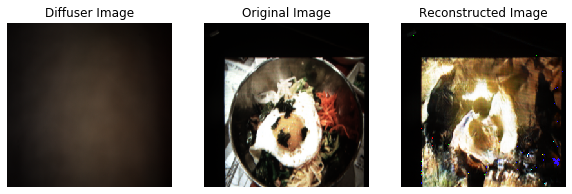

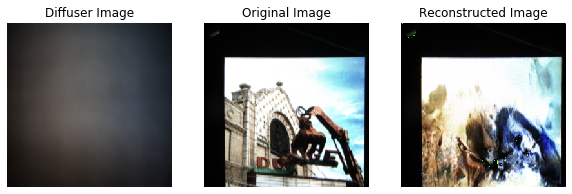

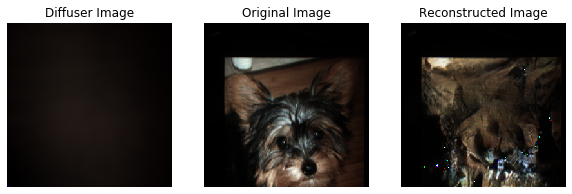

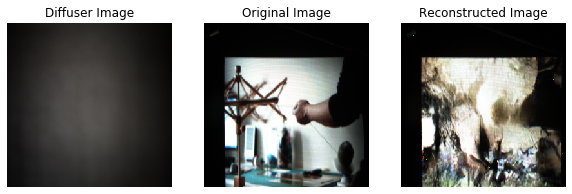

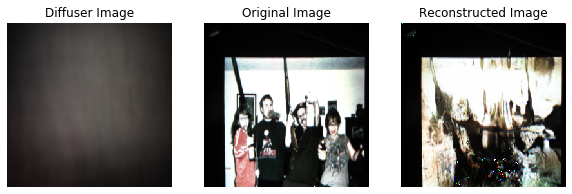

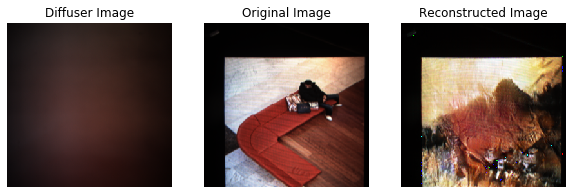

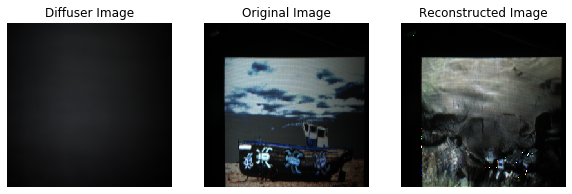

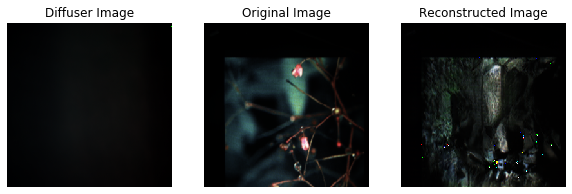

In [15]:
# model = load_model("Trained_Models/model_01200000.h5")
plot_sample_result(10, False)

In [30]:
model1 = load_model("Trained_Models/model_124995.h5")
model2 = load_model("Trained_Models/model_00400000.h5")
model3 = load_model("Trained_Models/model_01200000.h5")
model4 = load_model("Trained_Models/model_01600000.h5")

C:\Users\karth\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(-0.5, 255.5, 255.5, -0.5)

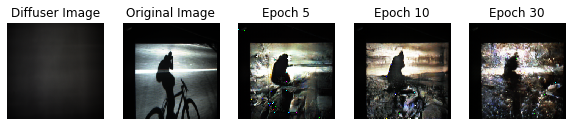

In [42]:
np.random.seed(70)
rn = randint(0,24999)

img1 = np.load("../Data/Dataset/diffuser_images/im"+str(rn)+".npy")
img1 = cv2.flip(cv2.resize(img1, (256,256)), 0)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,6))
plt.subplot(151, frame_on=False)
plt.title("Diffuser Image")
plt.axis("off")
plt.imshow((img1* 255).astype(np.uint8))

img2 = np.load("../Data/Dataset/ground_truth_lensed/im"+str(rn)+".npy")
img2 = cv2.flip(cv2.resize(img2, (256,256)), 0)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(10,6))
plt.subplot(152, frame_on=False)
plt.title("Original Image")
plt.axis("off")
plt.imshow((img2* 255).astype(np.uint8))

img_test = np.reshape(img1, (1,256,256,3))
pred_img = model1.predict(img_test)
pred_img = np.reshape(pred_img, (256,256,3))

# plt.figure(figsize=(10,6))
plt.subplot(153, frame_on=False)
plt.title("Epoch 5")
plt.imshow((pred_img* 255).astype(np.uint8))
plt.axis("off")

img_test = np.reshape(img1, (1,256,256,3))
pred_img = model2.predict(img_test)
pred_img = np.reshape(pred_img, (256,256,3))

# plt.figure(figsize=(10,6))
plt.subplot(154, frame_on=False)
plt.title("Epoch 10")
plt.imshow((pred_img* 255).astype(np.uint8))
plt.axis("off")

img_test = np.reshape(img1, (1,256,256,3))
pred_img = model3.predict(img_test)
pred_img = np.reshape(pred_img, (256,256,3))

# plt.figure(figsize=(10,6))
plt.subplot(155, frame_on=False)
plt.title("Epoch 15")
plt.imshow((pred_img* 255).astype(np.uint8))
plt.axis("off")

img_test = np.reshape(img1, (1,256,256,3))
pred_img = model4.predict(img_test)
pred_img = np.reshape(pred_img, (256,256,3))

# plt.figure(figsize=(10,6))
plt.subplot(155, frame_on=False)
plt.title("Epoch 30")
plt.imshow((pred_img* 255).astype(np.uint8))
plt.axis("off")